# Imports

In [229]:
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.special import logit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import multiprocessing

from linearmodels.iv import IV2SLS

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Functions

In [2]:
def create_covariates(n_samples, seed=0, n_binary=0, **kwargs):
    """
    Generates a covariate matrix of the given number of samples and features.
    
    Args:
        n_samples (int): number of samples to generate
        seed (int): seed for reproducibility
        n_binary (int): number of features to binarize
        **kwargs (dict): other keyword arguments passed to make_regression
    
    Returns:
        pd.DataFrame
    """
    print(kwargs)
    
    X, y = make_regression(n_samples=n_samples, random_state=seed, **kwargs)
    
    feat_cols = ["feat_" + str(x) for x in range(X.shape[1])]
    
    df = pd.DataFrame(X, columns=feat_cols)
    
    for i in range(n_binary):
        col = "feat_" + str(i)
        X[col] = (X[col] > X[col].mean()).astype(int)
        
    # min max scale to [-1, 1]
    rescale_y = -1 + ((y - np.min(y))*(1 - (-1)) / (np.max(y) - np.min(y)))
    
    df['comply_coeff'] = rescale_y

    return df
    

In [3]:
def gen_fuzzy_rdd_with_covariates(n_samples, fuzzy_gap, tau, take=0.0, seed=0, comply_scale=0.5, regression_dict={}):
    """
    Builds a fuzzy RDD with imperfect compliance, with many covariates that may influence compliance.

    p is the "true" probability of getting treatment, and is a function of x and the unknown covariate u.

    Params:
        n_samples (int): number of samples to draw
        fuzzy_fuzzy_gap (float): the fuzzy_gap in treatment probability, centered at 0.5. Max value is 1, and induces a sharp RDD.
        tau (float): the treatment effect on the outcome
        take (float): the coefficient for probability of taking treatment, defaults to 0.0
        seed (int): seed for reproducibility

    Returns:
        df (pd.DataFrame): pandas Dataframe with x,y,t,z,u,p populated (note, do not use u, p in regression)
    """
    np.random.seed(seed)

    # observed running variable
    x = np.random.uniform(0, 1, n_samples)

    # unobserved confounder
    u = np.random.normal(0, 0.1, n_samples)

    # boundary
    b = 0.5

    # boundary indicator
    d = (x > b).astype(int)

    gamma_p = np.random.normal(0, 1, 1)
    noise_p = np.random.normal(0, 1, n_samples)
    
    mu = d*(0.5 + fuzzy_gap/2) + (1-d)*(0.5 - fuzzy_gap/2)

    # TODO potential concern, polluting the treatment effect with x?
    p_take = take*(x-0.5) + u #(fuzzy_gap/2)
    #p_take = take*x - take/2 + u #(fuzzy_gap/2)

    
    feat_df = create_covariates(n_samples=n_samples, seed=seed, **regression_dict)
    
    p_adj = mu + p_take + (comply_scale * feat_df['comply_coeff'])
    p_adj = np.clip(p_adj, 0,1)

    # treatment indicator
    t = np.random.binomial(1, p_adj, n_samples)

    # outcome and treatment
    gamma_y = np.random.normal(0, 1, 1)
    noise_y = np.random.normal(0, 1, n_samples)
    y = x*gamma_y + t*tau + noise_y #+ u

    df = pd.DataFrame()
    df['x'] = x # running variable
    df['z'] = d # indicator for above/below threshold
    df['t'] = t # indicator for actual treatment assignment
    df['y'] = y # outcome
    df['p'] = p_adj # true probability of treatment
    df['u'] = u # "unobserved" noise affecting treatment

    df['x_lower'] = (1-df['z'])*(df['x'] - 0.5) # adjusted x for 2SLS
    df['x_upper'] = df['z']*(df['x'] - 0.5) # adjusted x for 2SLS
    df['p_compliance'] = (df['z']*df['p']) + (1-df['z'])*(1-df['p']) # probability of compliance
    df['complier_indicator'] = (df['z'] == df['t']).astype(int)
    
    # attach covariates that partially determine compliance
    df = pd.concat([df, feat_df], axis=1)
    
    return df

In [306]:
def gen_fuzzy_rdd(n_samples, fuzzy_gap, tau, take=0.0, seed=0, boundary=0.5):
    """
    Builds a fuzzy RDD with imperfect compliance.
    
    p is the "true" probability of getting treatment, and is a function of x and the unknown covariate u.
    
    Params:
        n_samples (int): number of samples to draw
        fuzzy_fuzzy_gap (float): the fuzzy_gap in treatment probability, centered at 0.5. Max value is 1, and induces a sharp RDD.
        tau (float): the treatment effect on the outcome
        take (float): the coefficient for probability of taking treatment, defaults to 0.2
        seed (int): seed for reproducibility
        
    Returns:
        df (pd.DataFrame): pandas Dataframe with x,y,t,z,u,p populated (note, do not use u, p in regression)
    """
    np.random.seed(seed)
    
    # observed covariates
    x = np.random.uniform(0, 1, n_samples)

    # unobserved confounder
    #u = np.random.uniform(-.1, 0.1, n_samples)
    u = np.random.normal(0, 0.1, n_samples)

    # boundary
    b = boundary

    # boundary indicator
    d = (x > b).astype(int)

    gamma_p = np.random.normal(0, 1, 1)
    noise_p = np.random.normal(0, 1, n_samples)

    
    mu = d*(0.5 + fuzzy_gap/2) + (1-d)*(0.5 - fuzzy_gap/2)
    #print(mu)
    p_take = take*x - take/2 + u #(fuzzy_gap/2)

    p_adj = mu + p_take
    p_adj = np.clip(p_adj, 0,1)

    # treatment indicator
    t = np.random.binomial(1, p_adj, n_samples)
    
    # outcome and treatment
    gamma_y = np.random.normal(0, 1, 1)
    noise_y = np.random.normal(0, 1, n_samples)
    y = x*gamma_y + t*tau + noise_y #+ u
    
    df = pd.DataFrame()
    df['x'] = x # running variable
    df['z'] = d # indicator for above/below threshold
    df['t'] = t # indicator for actual treatment assignment
    df['y'] = y # outcome
    df['p'] = p_adj # true probability of treatment
    df['u'] = u # "unobserved" covariate
    
    df['x_lower'] = (1-df['z'])*(df['x'] - 0.5) # adjusted x for 2SLS
    df['x_upper'] = df['z']*(df['x'] - 0.5) # adjusted x for 2SLS
    df['p_compliance'] = (df['z']*df['p']) + (1-df['z'])*(1-df['p']) # probability of compliance
    
    return df
    
def point_plot(x, target, df, scale, errwidth=0):
    sns.pointplot(np.floor(df[x]*scale) / scale, df[target], join=False, errwidth=errwidth)
    plt.xticks(np.arange(0,scale+1,scale/10), [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [304]:
def gen_fuzzy_rdd_2d(n_samples, fuzzy_gap, tau, take=0.0, seed=0, boundary=0.5):
    """
    Builds a fuzzy RDD with imperfect compliance.
    
    p is the "true" probability of getting treatment, and is a function of x and the unknown covariate u.
    
    Params:
        n_samples (int): number of samples to draw
        fuzzy_fuzzy_gap (float): the fuzzy_gap in treatment probability, centered at 0.5. Max value is 1, and induces a sharp RDD.
        tau (float): the treatment effect on the outcome
        take (float): the coefficient for probability of taking treatment, defaults to 0.2
        seed (int): seed for reproducibility
        
    Returns:
        df (pd.DataFrame): pandas Dataframe with x,y,t,z,u,p populated (note, do not use u, p in regression)
    """
    np.random.seed(seed)
    
    # observed covariates
    x1 = np.random.uniform(0, 1, n_samples)
    x2 = np.random.uniform(0, 1, n_samples)

    # unobserved confounder
    #u = np.random.uniform(-.1, 0.1, n_samples)
    u = np.random.normal(0, 0.1, n_samples)

    # boundary
    b = boundary

    # boundary indicator
    d = ((x1 > b) & (x2 > b)).astype(int)

    gamma_p = np.random.normal(0, 1, 1)
    noise_p = np.random.normal(0, 1, n_samples)

    
    mu = d*(0.5 + fuzzy_gap/2) + (1-d)*(0.5 - fuzzy_gap/2)
    #print(mu)
    p_take = take/2*x1 + take/2*x2 - take/4 + u #(fuzzy_gap/2)

    p_adj = mu + p_take
    p_adj = np.clip(p_adj, 0,1)

    # treatment indicator
    t = np.random.binomial(1, p_adj, n_samples)
    
    # outcome and treatment
    gamma_y = np.random.normal(0, 1, 1)
    noise_y = np.random.normal(0, 1, n_samples)
    y = (x1*gamma_y/2) + (x2*gamma_y/2) + t*tau + noise_y #+ u
    
    df = pd.DataFrame()
    df['x1'] = x1 # running variable
    df['x2'] = x2 # running variable
    df['z'] = d # indicator for above/below threshold
    df['t'] = t # indicator for actual treatment assignment
    df['y'] = y # outcome
    df['p'] = p_adj # true probability of treatment
    df['u'] = u # "unobserved" covariate
    
    #df['x_lower'] = (1-df['z'])*(df['x'] - 0.5) # adjusted x for 2SLS
    #df['x_upper'] = df['z']*(df['x'] - 0.5) # adjusted x for 2SLS
    df['p_compliance'] = (df['z']*df['p']) + (1-df['z'])*(1-df['p']) # probability of compliance
    
    return df

# Generate data, 1D

In [5]:
n = 1000
df = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0)

In [6]:
lr = LogisticRegression(random_state=0)
X = df['x'].values.reshape(-1, 1)
print(X.shape)
lr.fit(X, df['t'])
test_X = np.linspace(0,1,100).reshape(-1, 1)
preds = lr.predict_proba(test_X)[:, 1]

(1000, 1)


In [7]:
df['x'].describe()

count    1000.000000
mean        0.495922
std         0.290744
min         0.000546
25%         0.247613
50%         0.481323
75%         0.737260
max         0.999809
Name: x, dtype: float64

In [8]:
df['t'].describe()

count    1000.000000
mean        0.492000
std         0.500186
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: t, dtype: float64

## Propensity score

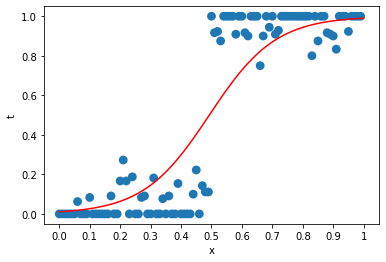

In [10]:
scale=100
point_plot('x', 't', df, scale, errwidth=0)
disp_X = np.floor(test_X.flatten()*scale)
sns.lineplot(disp_X, preds, color='red')


## Density of X

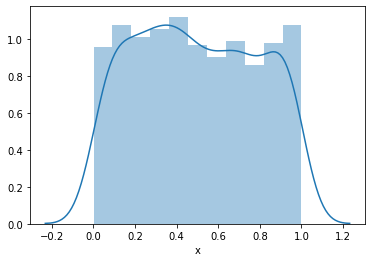

In [11]:
sns.distplot(df['x'])

In [161]:
from scipy.misc import derivative

def get_deriv(x, pTreat):
    """calculates the derivative at x for pTreat"""
    
    def model_call(x):
        return pTreat.predict_proba(x.reshape(-1,1))[0,1]
    
    return derivative(model_call, x, dx=1e-6, order=3)

In [162]:
xs = np.linspace(0,1,100)

dTdx = [get_deriv(x, lr) for x in xs]

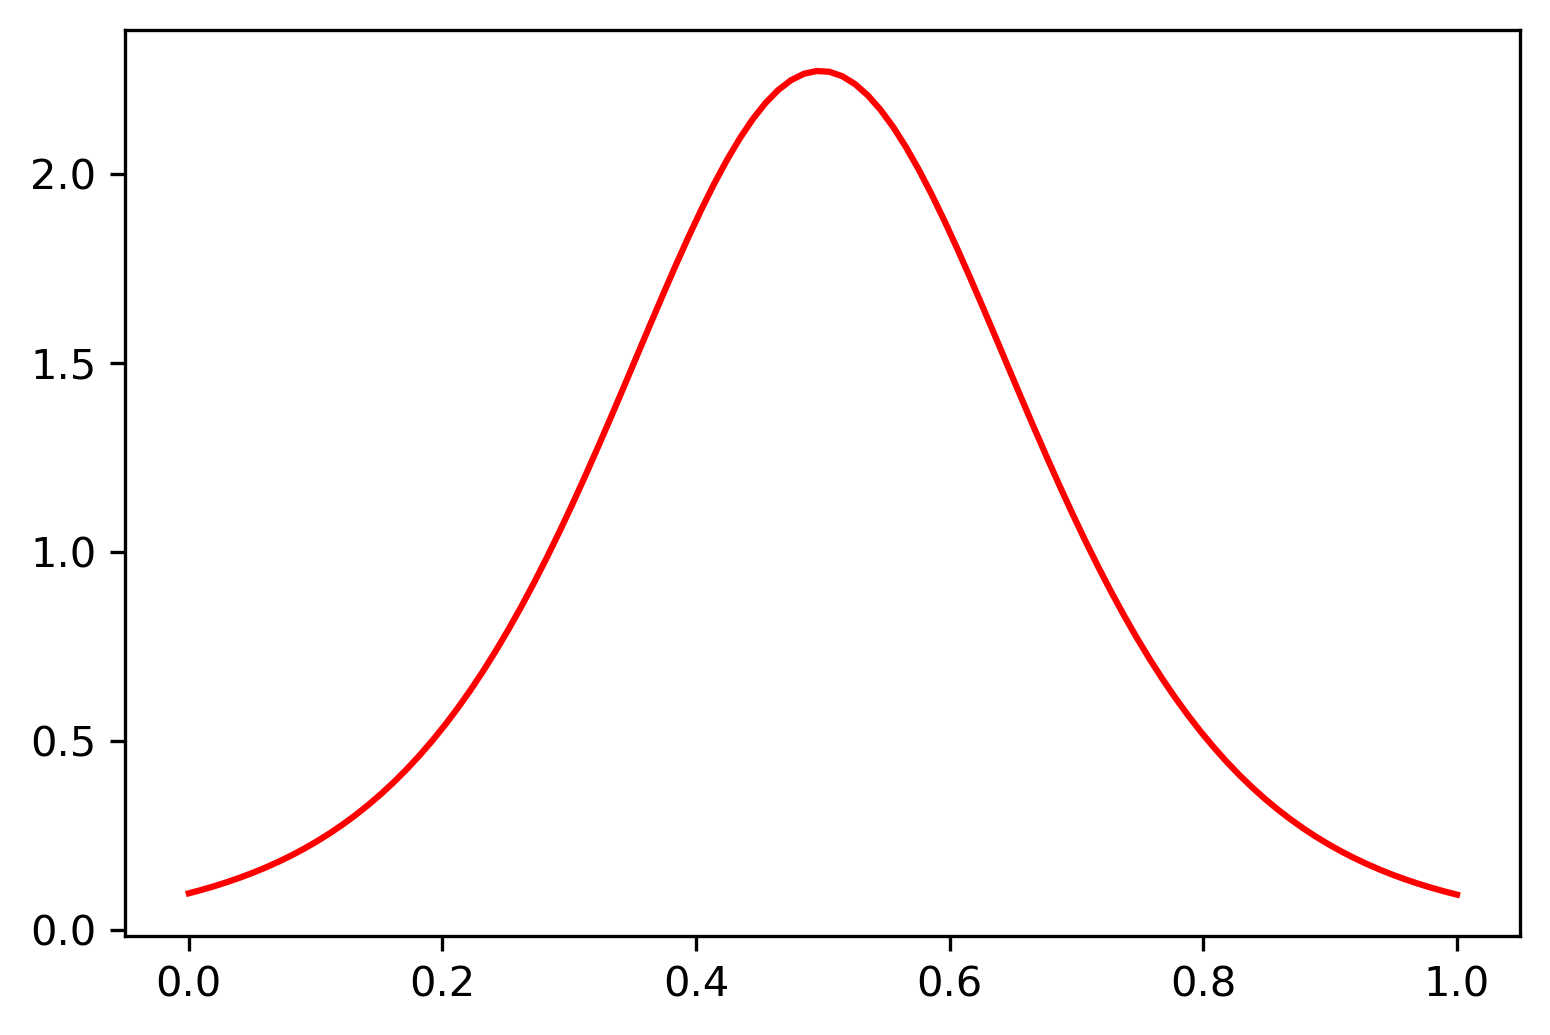

In [163]:
sns.lineplot(xs, dTdx, color='red')

In [28]:
xs[np.argmax(dTdx)]

0.494949494949495

# Generate data, 2D

In [30]:
n = 1000
r2d_df = gen_fuzzy_rdd_2d(n, 0.8, 0.8, 0.2, seed=0)

## Probability treat

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'thresh', 'fill'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


Text(0.5, 1.0, 'density of p(T)')

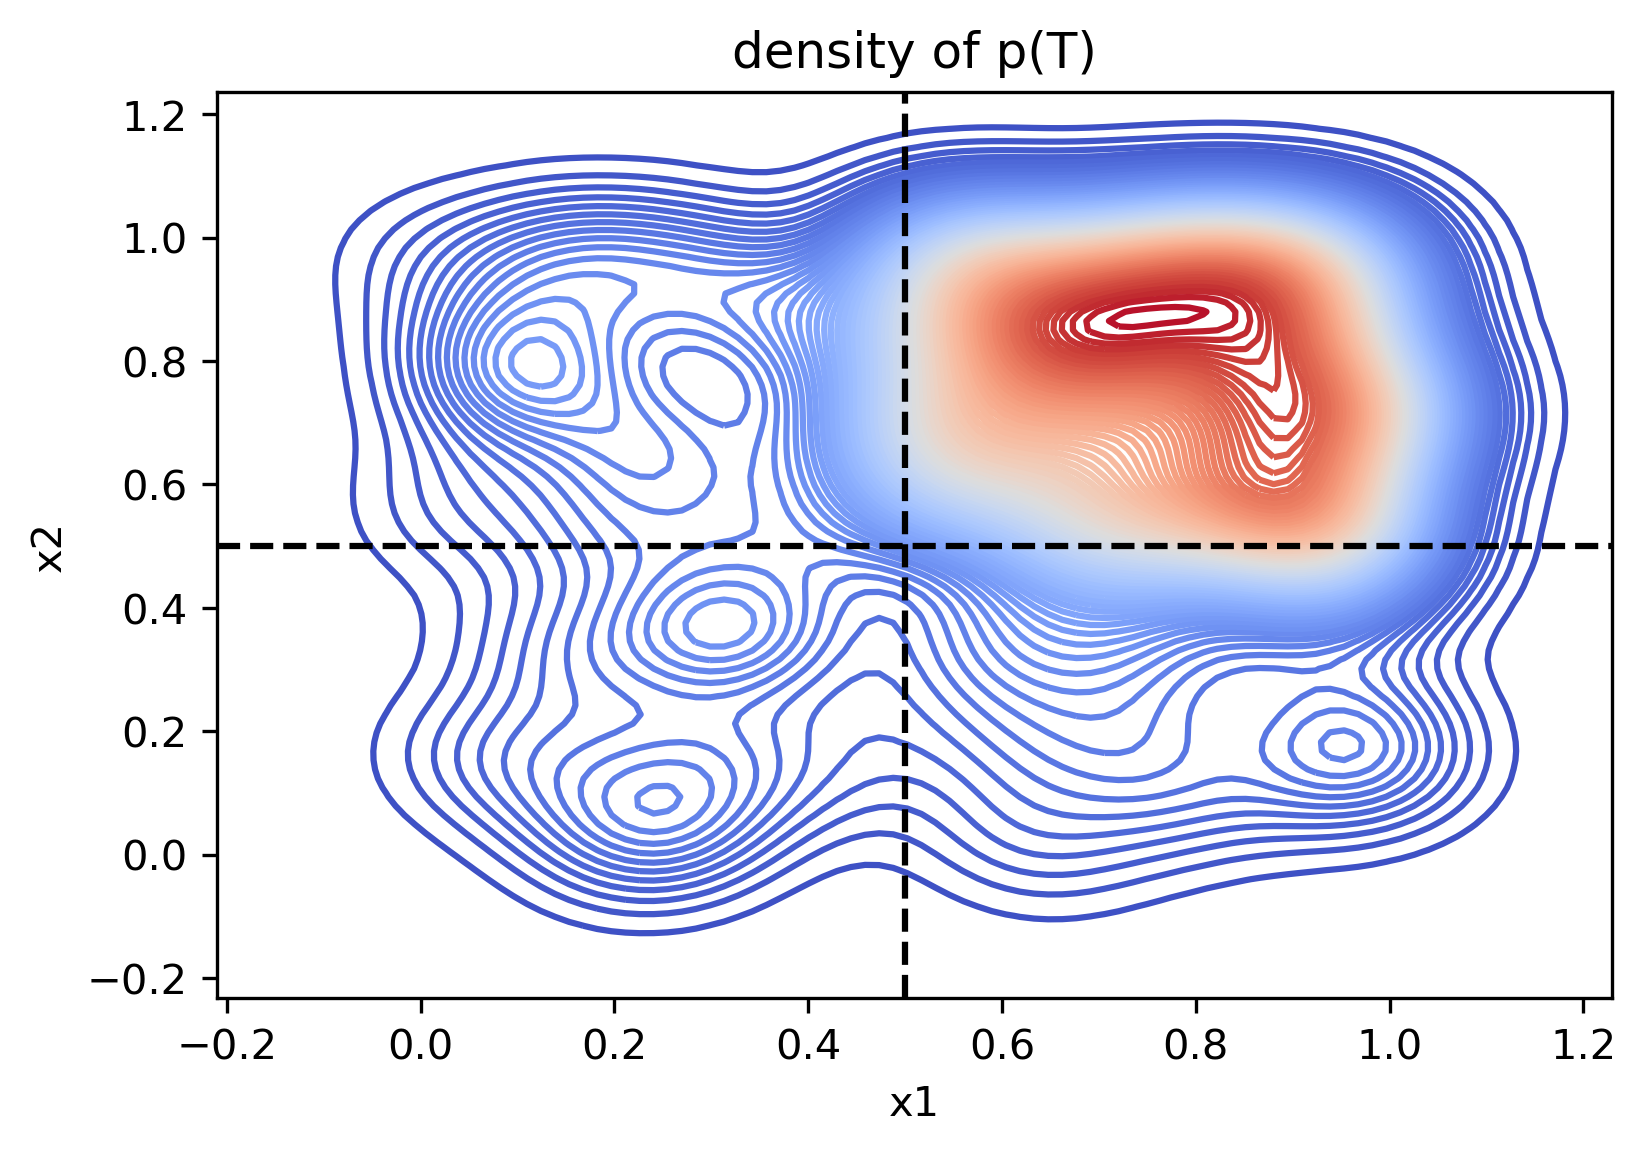

In [287]:
treat_df = r2d_df[r2d_df['t'] == 1]

sns.kdeplot(treat_df['x1'], treat_df['x2'], thresh=0, levels=100, fill=True, cmap='coolwarm')
plt.axvline(x=0.5, ls='--', color='black')
plt.axhline(y=0.5, ls='--', color='black')
plt.title("density of p(T)")

## Predicted probability, LR

In [32]:
lr_2d = LogisticRegression(random_state=0)
X = r2d_df[['x1', 'x2']]
print(X.shape)
lr_2d.fit(X, r2d_df['t'])

(1000, 2)


LogisticRegression(random_state=0)

In [101]:
x1s = np.linspace(0,1,100)
x2s = np.linspace(1,0,100)

xx,yy = np.meshgrid(x1s,x2s, indexing='xy')

In [103]:
probs = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]]).reshape(1,2)
        probs[i,j] = lr_2d.predict_proba(point)[0,1]

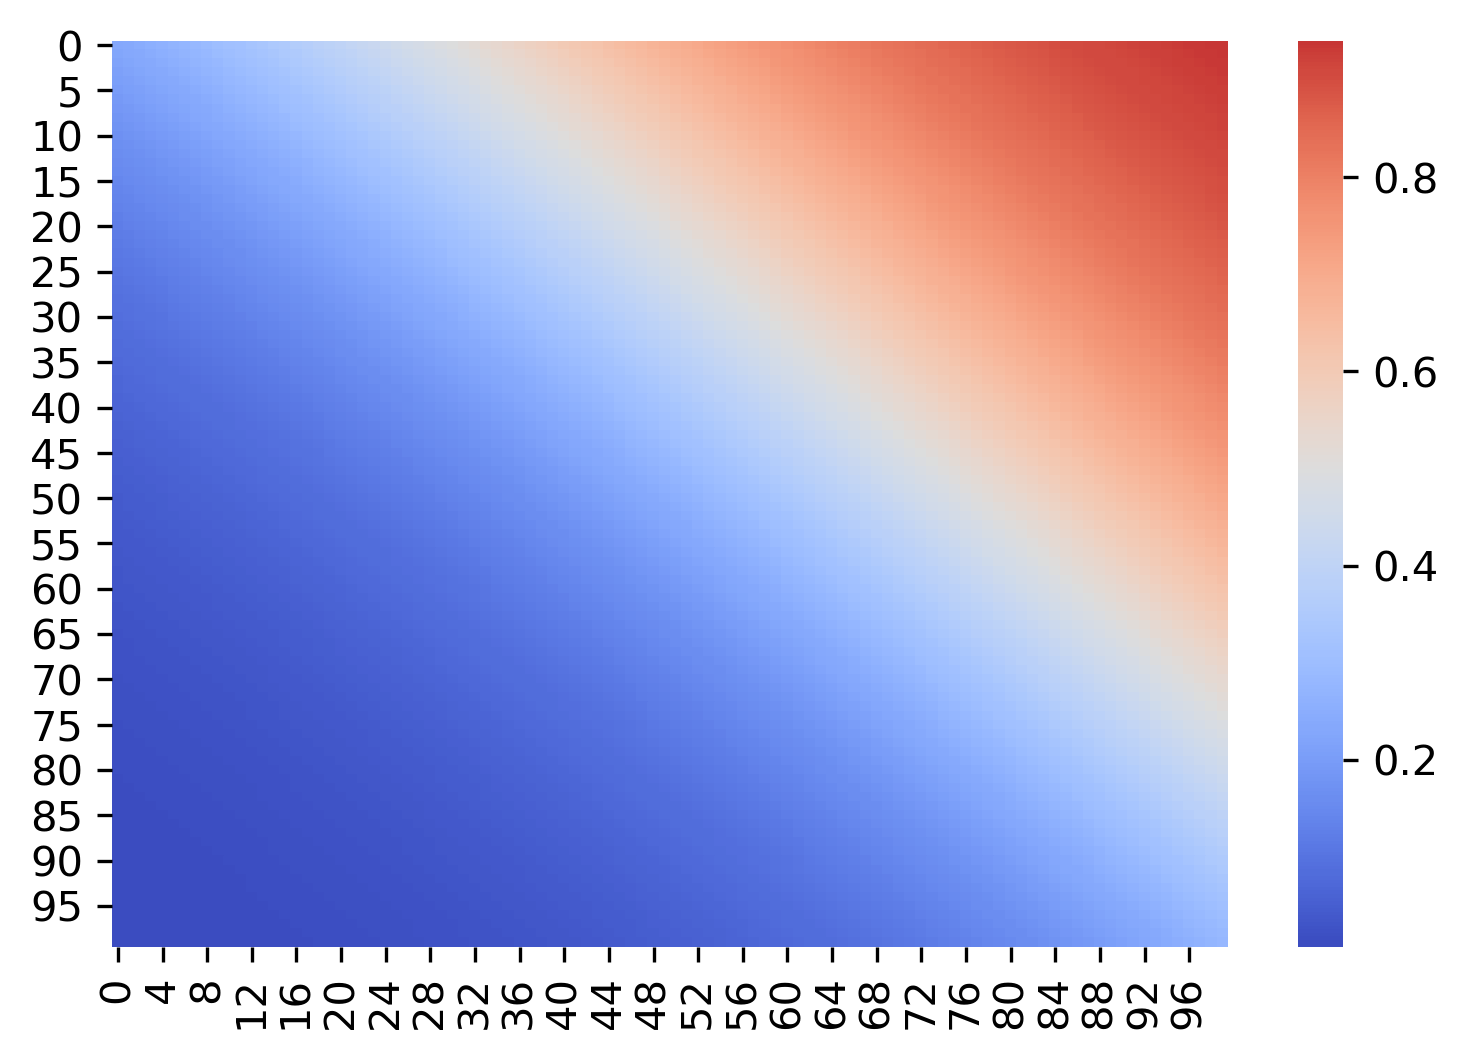

In [115]:
sns.heatmap(probs, center=0.5, cmap='coolwarm')

## Predicted probability, random forest

In [300]:
tree_2d = RandomForestClassifier(n_estimators=100,
                                 min_samples_split=10)
X = r2d_df[['x1', 'x2']]
print(X.shape)
tree_2d.fit(X, r2d_df['t'])

(1000, 2)


RandomForestClassifier(min_samples_split=10)

In [301]:
%%time

tree_probs = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]]).reshape(1,2)
        tree_probs[i,j] = tree_2d.predict_proba(point)[0,1]

CPU times: user 1min 30s, sys: 58.6 ms, total: 1min 30s
Wall time: 1min 30s


Text(0.5, 1.0, 'Propensity score')

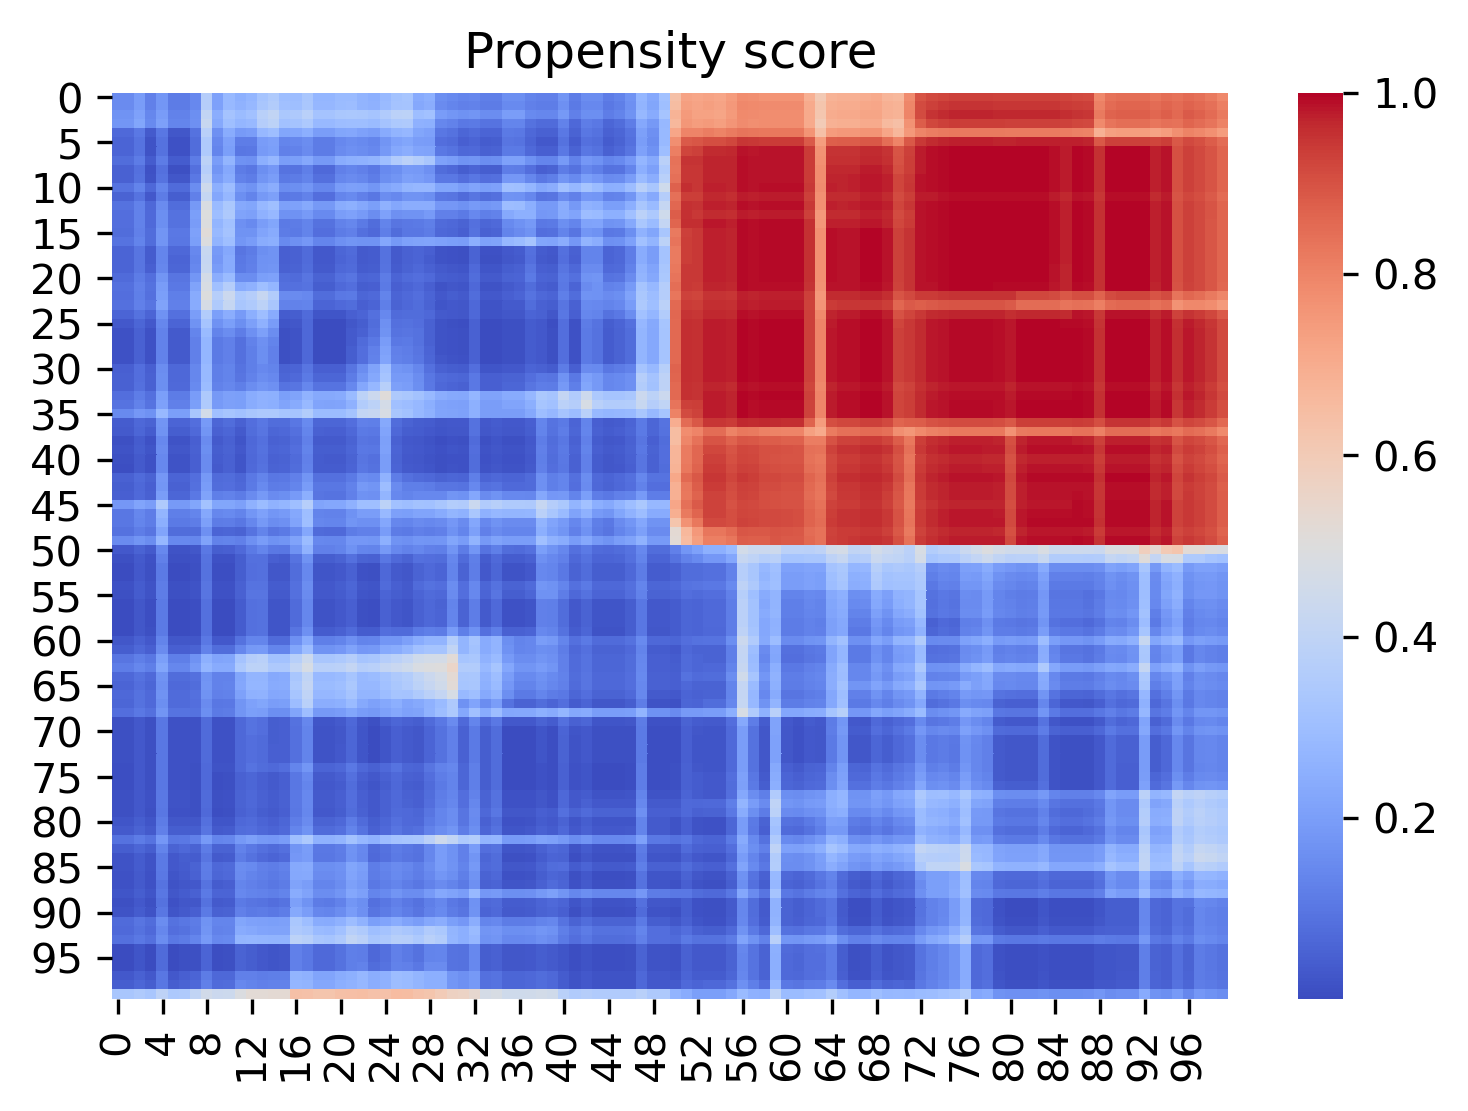

In [303]:
sns.heatmap(tree_probs, center=0.5, cmap='coolwarm')
plt.title("Propensity score")

## Derivative plots

In [264]:
from scipy.misc import derivative
from scipy.optimize import approx_fprime

def get_partial(x, pTreat):
    """calculates the partial derivative for x[idx] """
    
    def model_call(inst):
        #inst = x.copy()
        #inst[0, idx] = x_1d
        
        return pTreat.predict_proba(inst.reshape(1,2))[0,1]
    
    return approx_fprime(x, model_call, epsilon=5e-3)u

In [266]:
%%time

dTdx1 = np.zeros((100,100))
dTdx2 = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]])#.reshape(1,2)
        result = get_partial(point, tree_2d)
        dTdx1[i,j] = result[0]
        dTdx2[i,j] = result[1]

CPU times: user 2min 40s, sys: 246 ms, total: 2min 41s
Wall time: 2min 41s


([], <a list of 0 Text major ticklabel objects>)

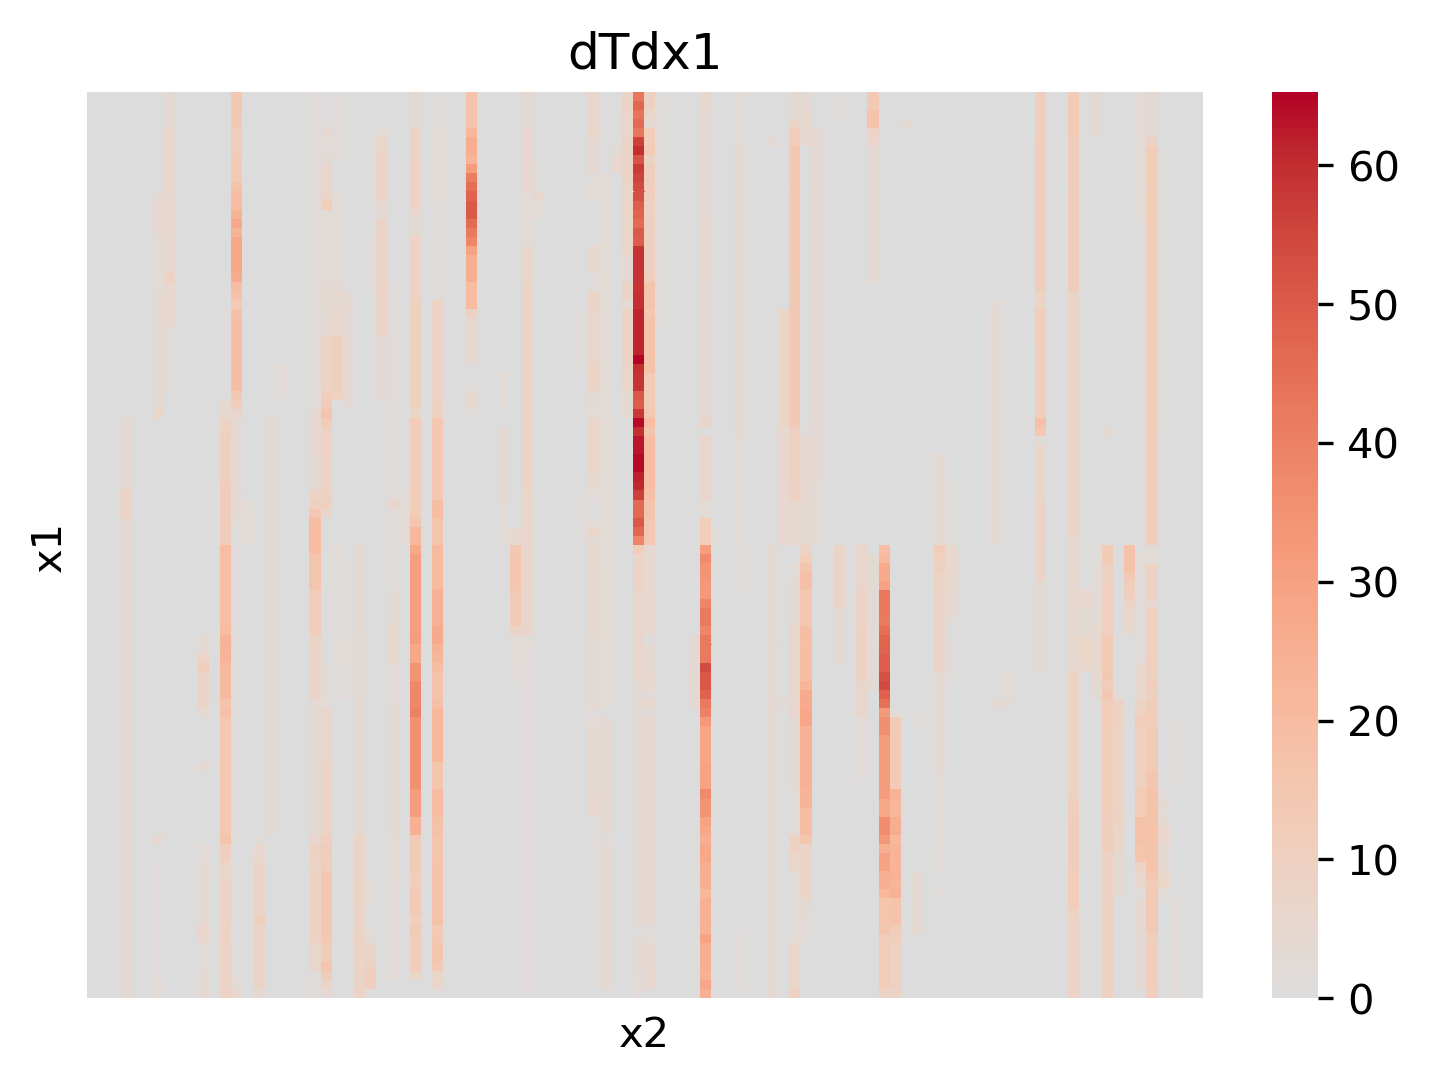

In [297]:
sns.heatmap(dTdx1, cmap='coolwarm', vmin=0, center=0)
plt.title("dTdx1")
plt.xlabel("x2")
plt.ylabel("x1")
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

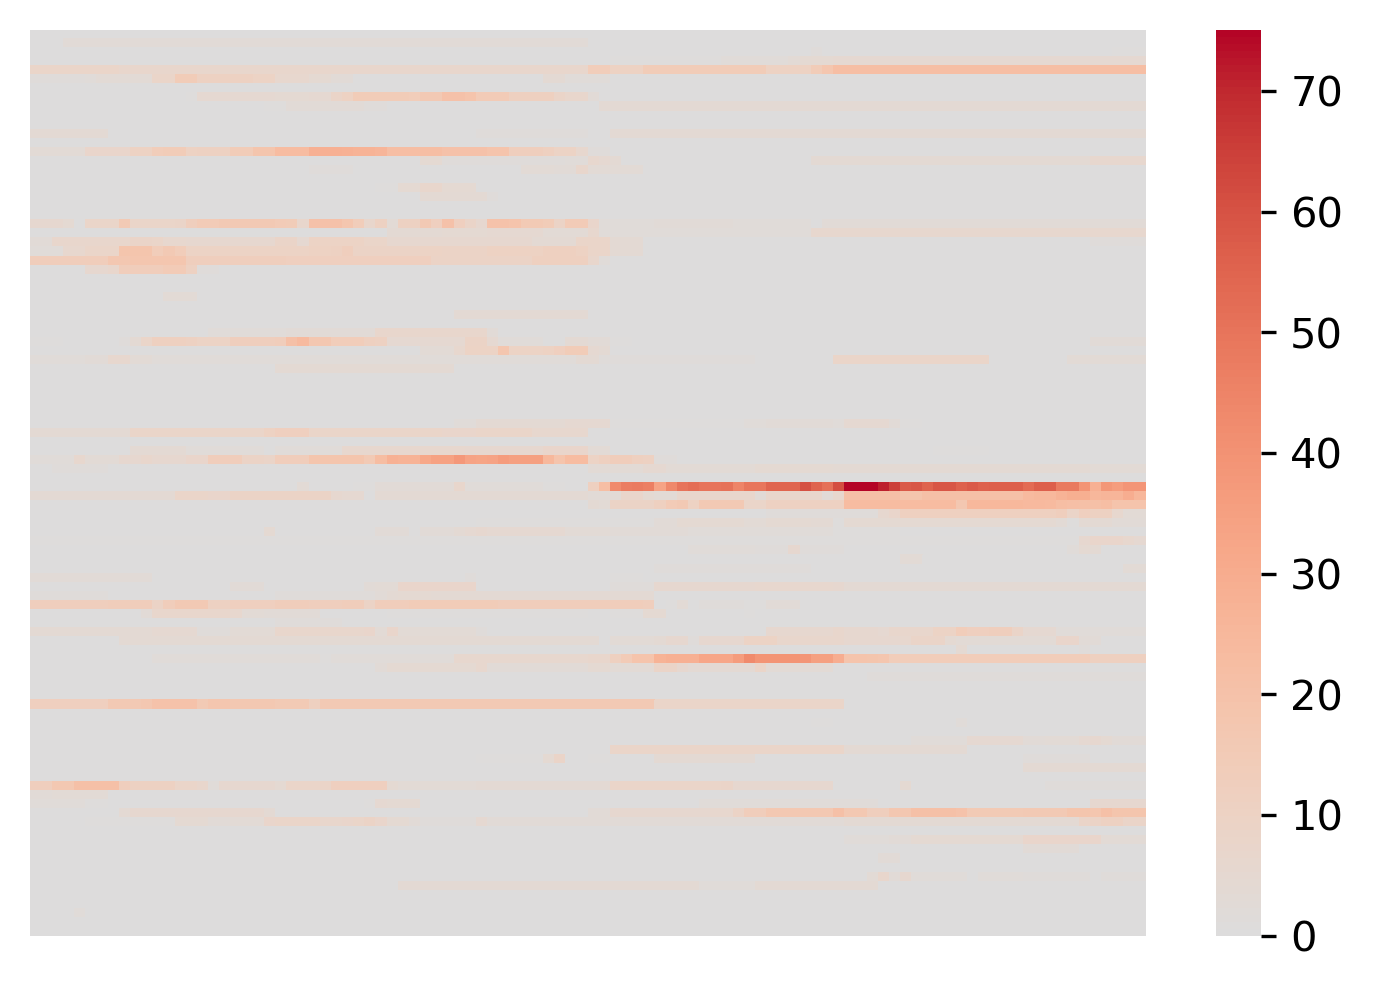

In [299]:
sns.heatmap(dTdx2, cmap='coolwarm', vmin=0, center=0)
plt.xticks([])
plt.yticks([])

In [236]:
%%time

dTdx1 = np.zeros((100,100))
dTdx2 = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]])#.reshape(1,2)
        result = get_partial(point, lr_2d)
        dTdx1[i,j] = result[0]
        dTdx2[i,j] = result[1]

CPU times: user 2.67 s, sys: 84.6 ms, total: 2.76 s
Wall time: 2.67 s


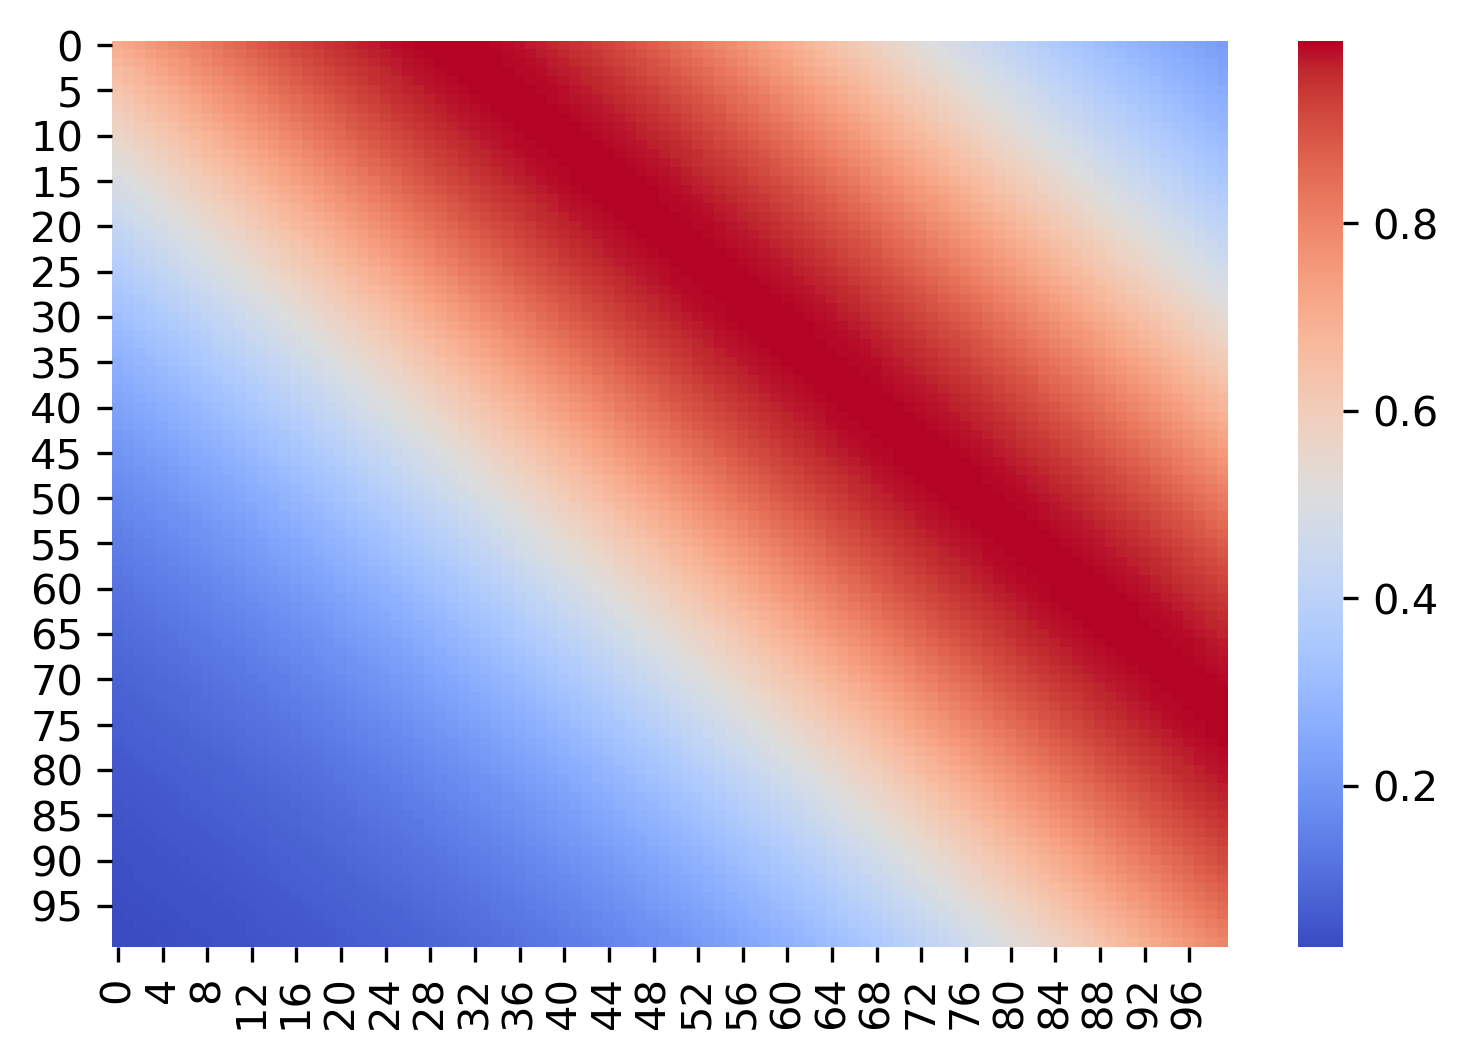

In [237]:
sns.heatmap(dTdx1, cmap='coolwarm')

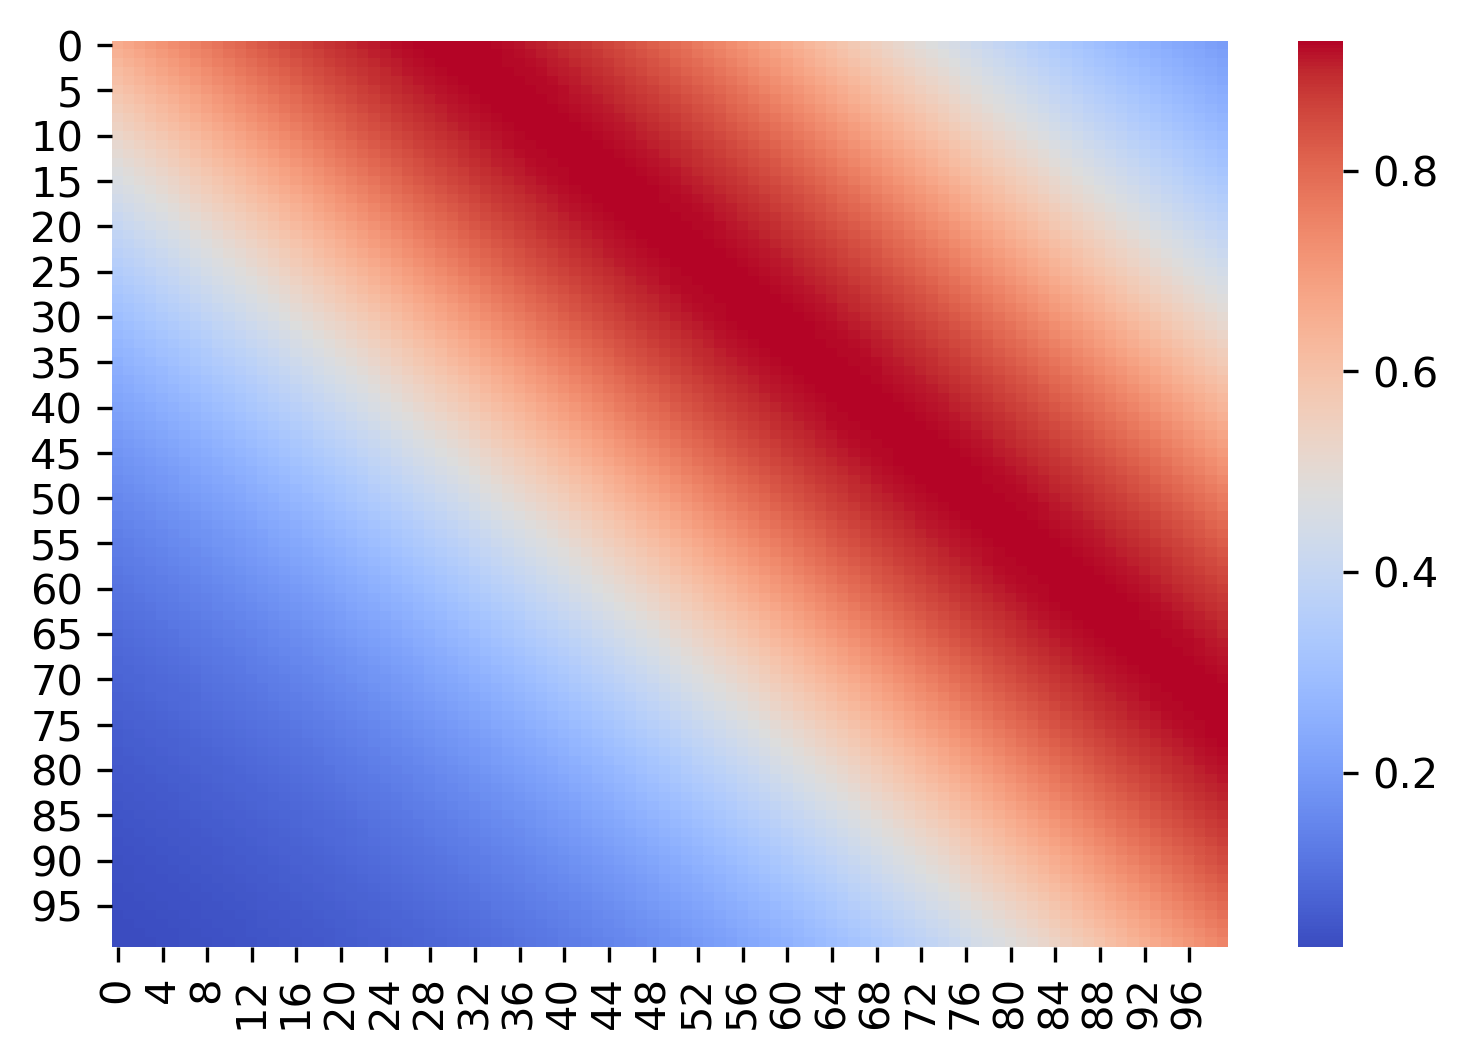

In [238]:
sns.heatmap(dTdx2, cmap='coolwarm')

# Blended RDD

Simulation setup:

- two RDDs with different thresholds based on race

## Generate data

In [307]:
n = 1000
df1 = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0, boundary=0.4)
df2 = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0, boundary=0.6)

df1['cat'] = 1
df2['cat'] = 0

blend_df = df1.append(df2)
blend_df = blend_df.sample(frac=1).reset_index(drop=True)

In [308]:
blend_df.head()

,x,z,t,y,p,u,x_lower,x_upper,p_compliance,cat
0,0.694158,1,1,-0.790325,0.991591,0.052760,0.000000,0.194158,0.991591,0
1,0.813798,1,1,0.407589,1.000000,0.132646,0.000000,0.313798,1.000000,0
2,0.056848,0,0,0.656100,0.046187,0.034817,-0.443152,-0.000000,0.953813,1
3,0.962189,1,1,1.235278,1.000000,0.086565,0.000000,0.462189,1.000000,0
4,0.483394,1,1,-2.187649,0.906279,0.009600,-0.000000,-0.016606,0.906279,1


In [310]:
lr = LogisticRegression(random_state=0)
X = blend_df['x'].values.reshape(-1, 1)
print(X.shape)
lr.fit(X, blend_df['t'])
test_X = np.linspace(0,1,100).reshape(-1, 1)
preds = lr.predict_proba(test_X)[:, 1]

(2000, 1)


In [312]:
blend_df['x'].describe()

count    2000.000000
mean        0.495922
std         0.290672
min         0.000546
25%         0.247613
50%         0.481323
75%         0.737260
max         0.999809
Name: x, dtype: float64

In [313]:
blend_df['t'].describe()

count    2000.000000
mean        0.493500
std         0.500083
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: t, dtype: float64

## Propensity score

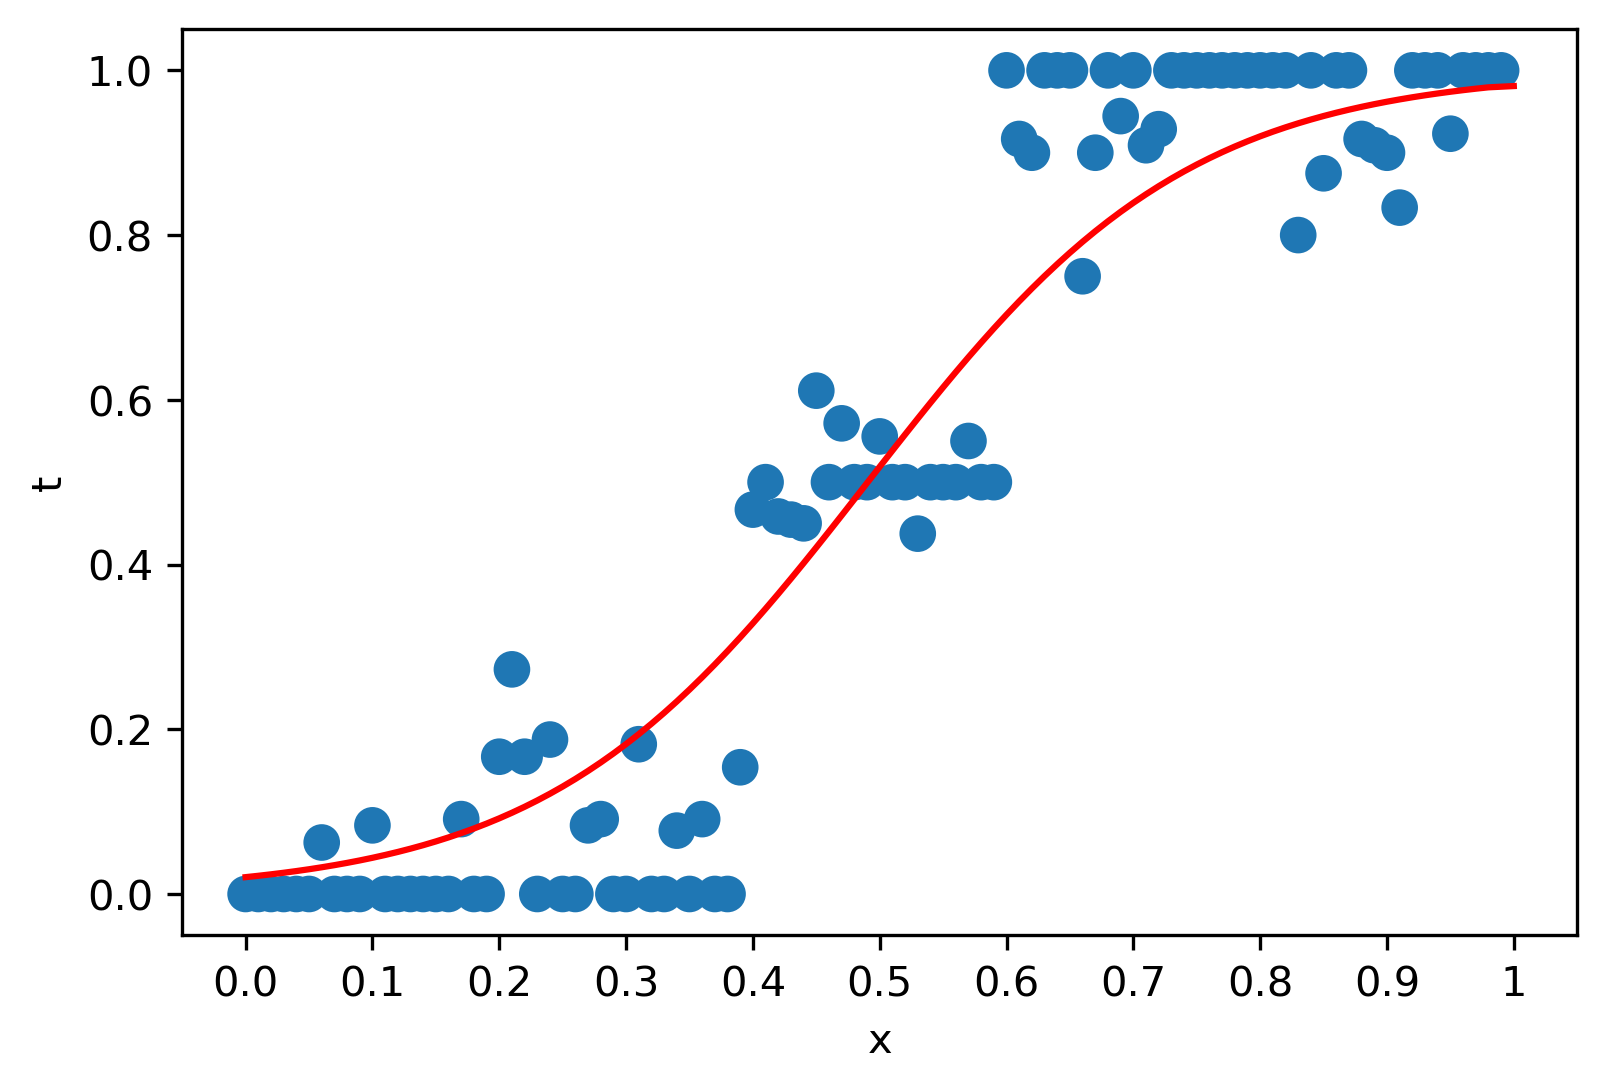

In [485]:
scale=100
point_plot('x', 't', blend_df, scale, errwidth=0)
disp_X = np.floor(test_X.flatten()*scale)
sns.lineplot(disp_X, preds, color='red')


## Probability treat

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'thresh', 'fill'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


(0.0, 1.0)

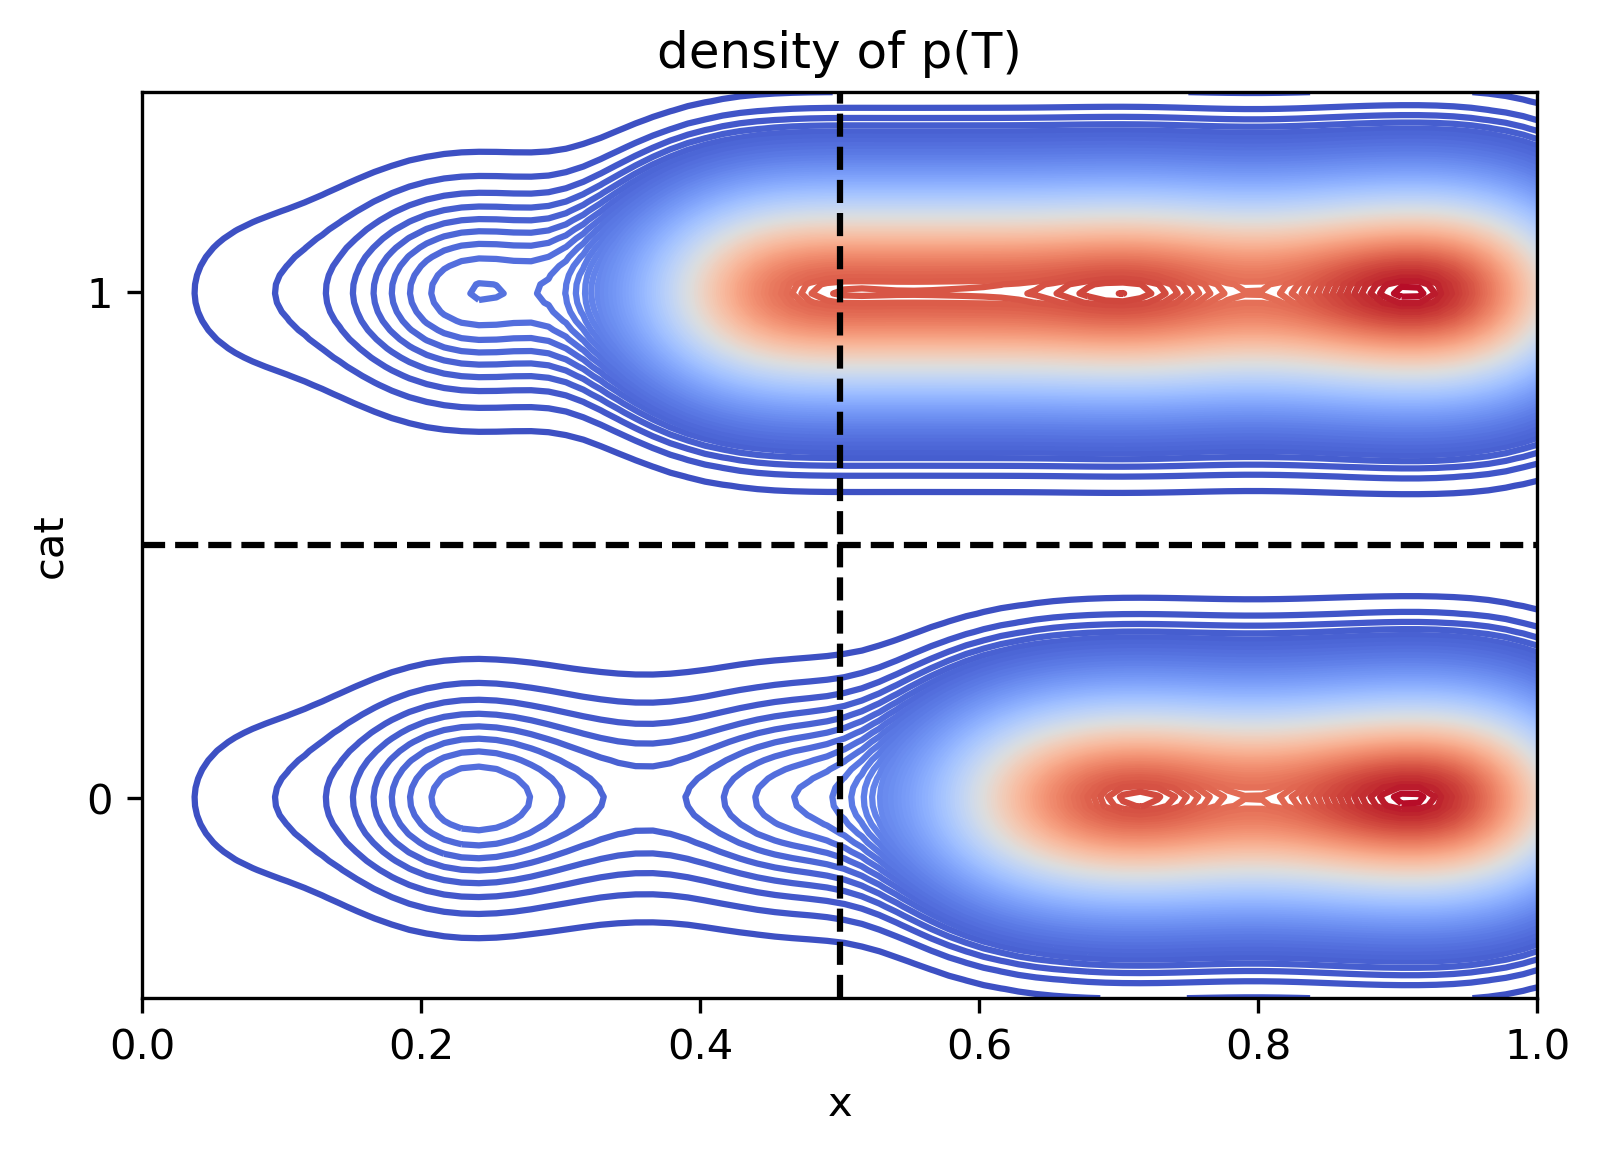

In [486]:
blend_t_df = blend_df[blend_df['t'] == 1]

sns.kdeplot(blend_t_df['x'], blend_t_df['cat'], thresh=0, levels=100, fill=True, cmap='coolwarm')
plt.axvline(x=0.5, ls='--', color='black')
plt.axhline(y=0.5, ls='--', color='black')
plt.title("density of p(T)")
plt.yticks([0,1])
plt.xlim(0,1)

## Predicted probability, LR

In [382]:
blend_lr = LogisticRegression(random_state=0)
X = blend_df[['x', 'cat']]
print(X.shape)
blend_lr.fit(X, blend_df['t'])

(2000, 2)


LogisticRegression(random_state=0)

In [383]:
x1s = np.linspace(0,1,100)
x2s = [0,1]

xx,yy = np.meshgrid(x1s,x2s, indexing='xy')

In [384]:
yy.shape

(2, 100)

In [385]:
probs = np.zeros((2,100))

for i in range(2):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]]).reshape(1,2)
        probs[i,j] = blend_lr.predict_proba(point)[0,1]

Text(0.5, 1.0, 'Propensity LR')

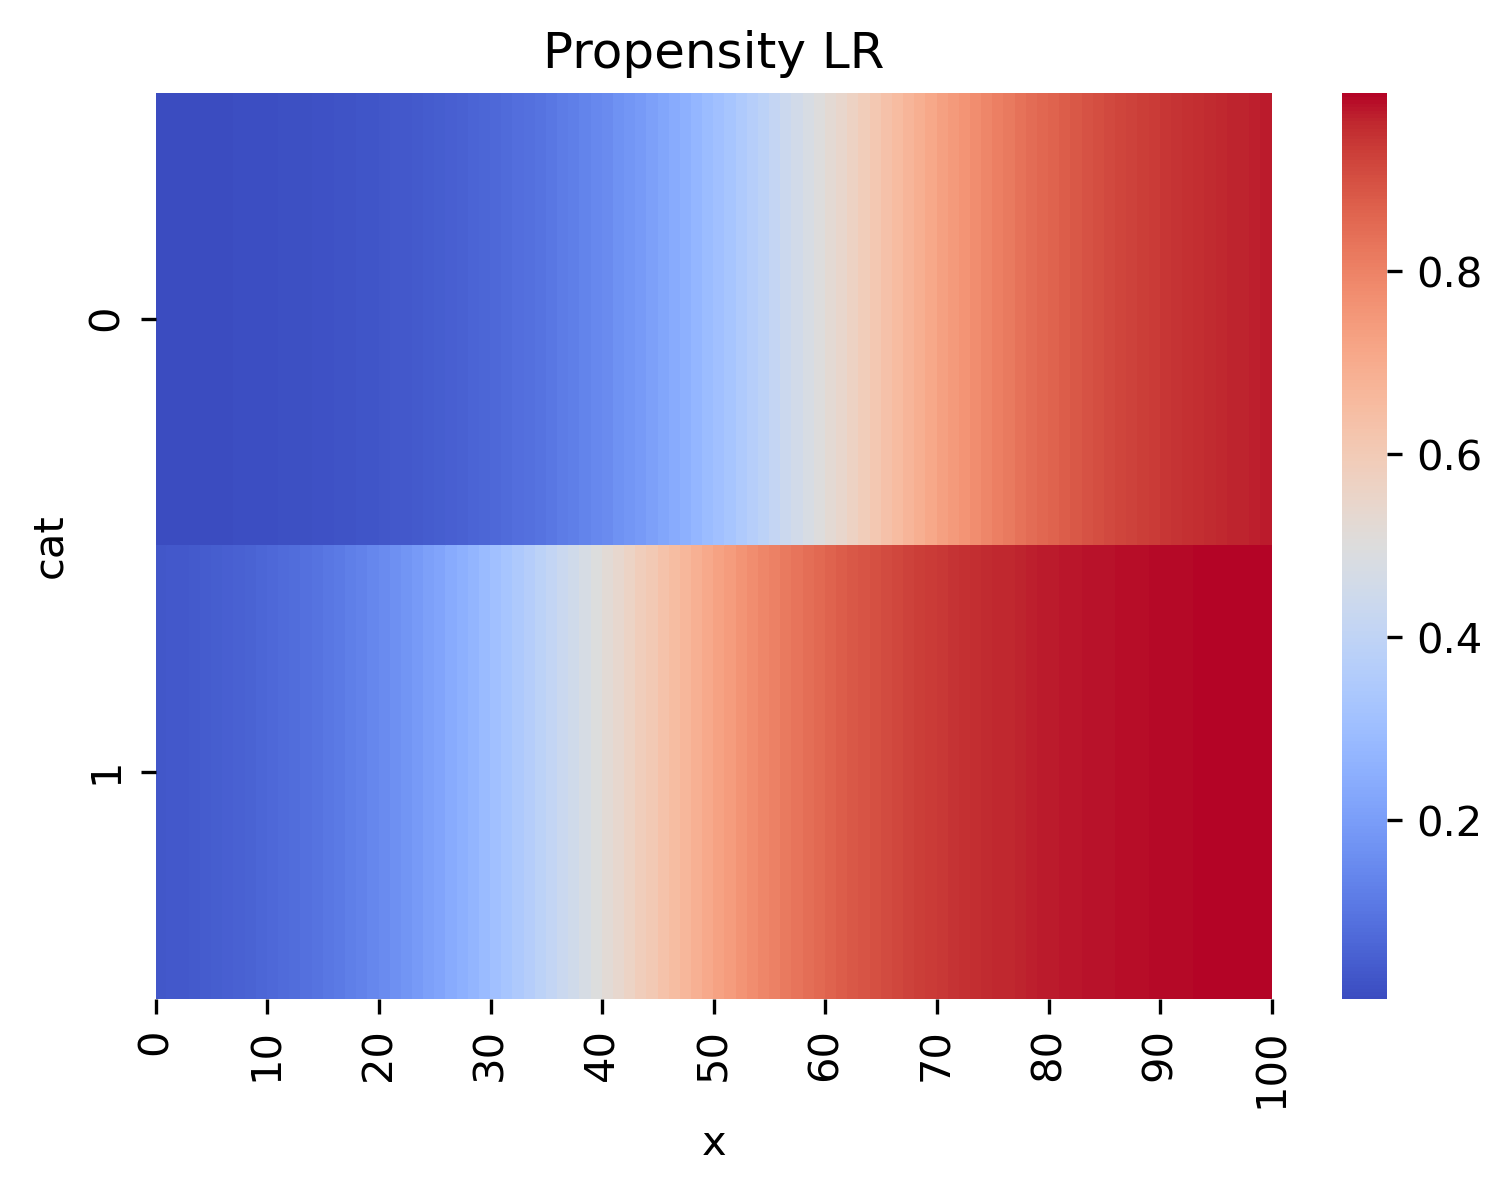

In [487]:
sns.heatmap(probs, center=0.5, cmap='coolwarm')

#plt.yticks([0.5,1.5], [1,0]);
plt.xticks(range(0,101,10), range(0,101,10))
plt.ylabel("cat")
plt.xlabel("x")
plt.title("Propensity LR")

### Derivatives

In [414]:
%%time

dTdx_cat = np.zeros((2,100))

for i in range(2):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]])#.reshape(1,2)
        result = get_partial(point, blend_lr)
        dTdx_cat[i,j] = result[0]

CPU times: user 105 ms, sys: 16.1 ms, total: 121 ms
Wall time: 111 ms


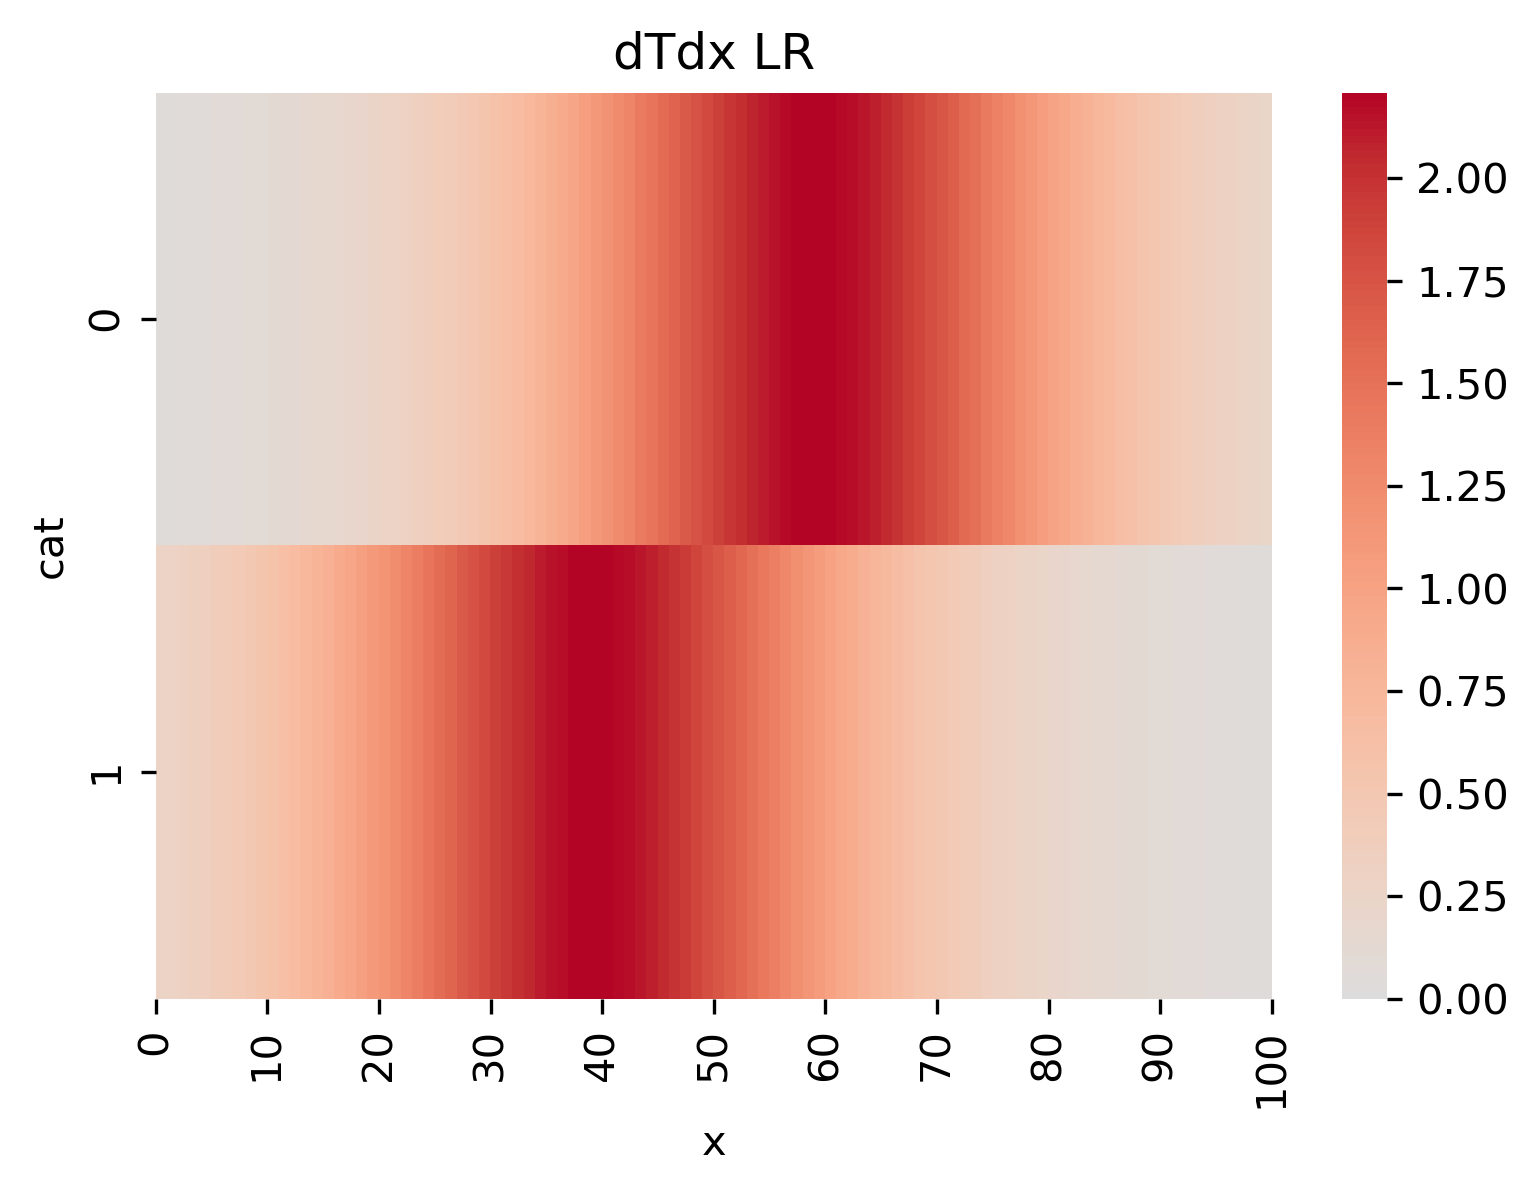

In [488]:
sns.heatmap(dTdx_cat, cmap='coolwarm', vmin=0, center=0)
plt.title("dTdx LR")
plt.xlabel("x")
plt.ylabel("cat")
plt.xticks(range(0,101,10), range(0,101,10));

## Predicted probability, random forest

In [419]:
blend_tree = RandomForestClassifier(n_estimators=1000,
                                 min_samples_split=20)
X = blend_df[['x', 'cat']]
print(X.shape)
blend_tree.fit(X, blend_df['t'])

(2000, 2)


RandomForestClassifier(min_samples_split=20, n_estimators=1000)

In [420]:
%%time

tree_probs = np.zeros((2,100))

for i in range(2):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]]).reshape(1,2)
        tree_probs[i,j] = blend_tree.predict_proba(point)[0,1]

CPU times: user 17.4 s, sys: 18.9 ms, total: 17.4 s
Wall time: 17.4 s


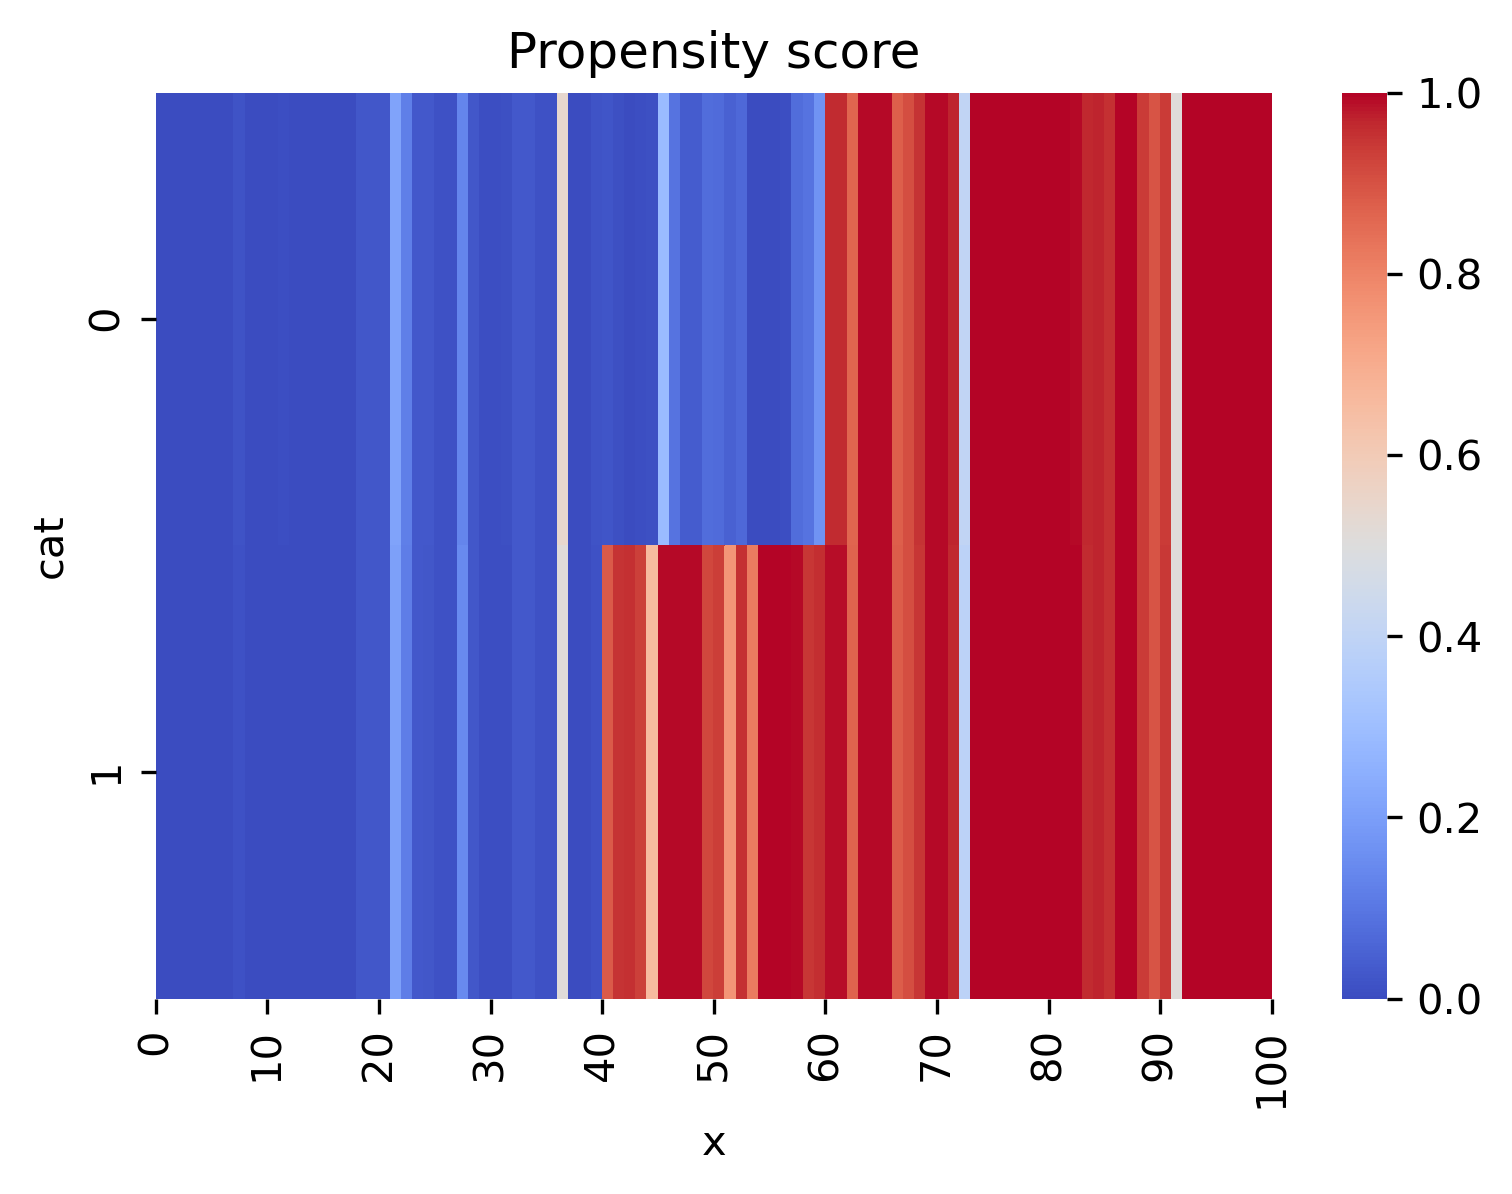

In [421]:
sns.heatmap(tree_probs, center=0.5, cmap='coolwarm')
plt.title("Propensity score")
#plt.xticks(np.linspace(0,100))
#plt.yticks([0.5,1.5], [1,0]);
plt.xticks(range(0,101,10), range(0,101,10))
plt.ylabel("cat")
plt.xlabel("x");

### Derivatives

In [422]:
%%time

dTdx_cat = np.zeros((2,100))

for i in range(2):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]])#.reshape(1,2)
        result = get_partial(point, blend_tree)
        dTdx_cat[i,j] = result[0]

CPU times: user 52.6 s, sys: 81.3 ms, total: 52.7 s
Wall time: 52.6 s


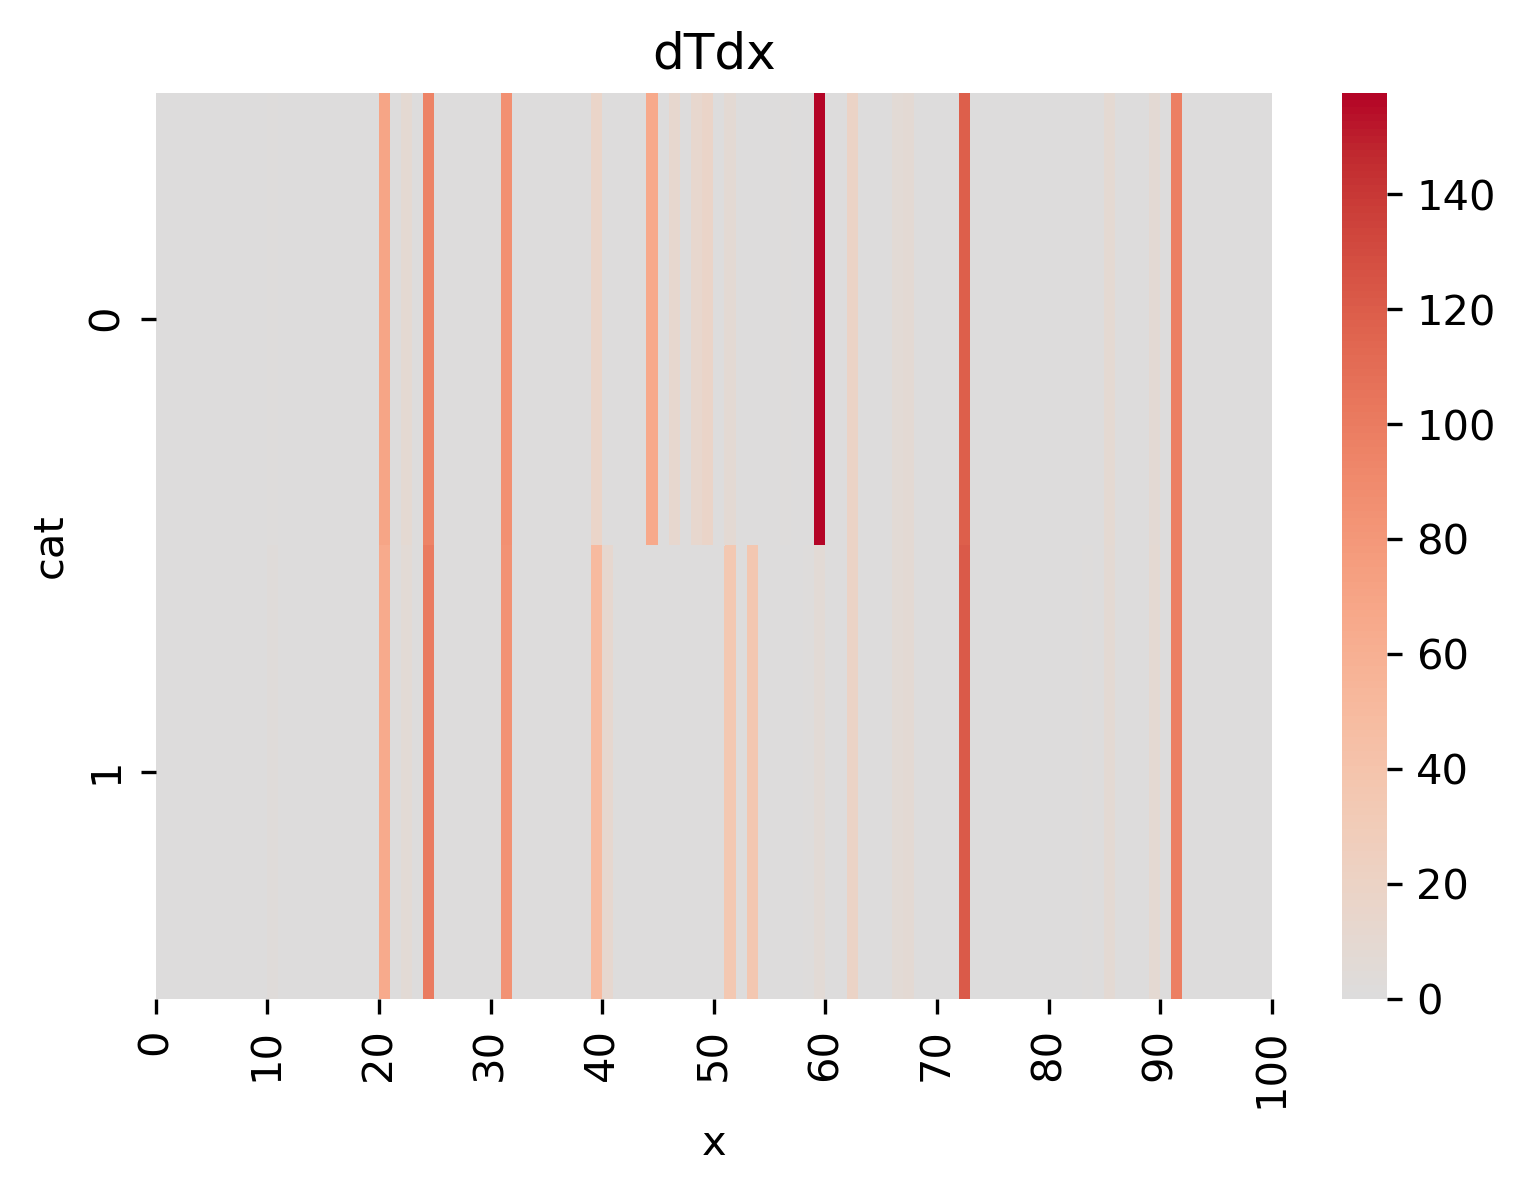

In [423]:
sns.heatmap(dTdx_cat, cmap='coolwarm', vmin=0, center=0)
plt.title("dTdx")
plt.xlabel("x")
plt.ylabel("cat")
plt.xticks(range(0,101,10), range(0,101,10));

# Negative control

Text(0.5, 1.0, 'Blended p(treat), no discontinuity')

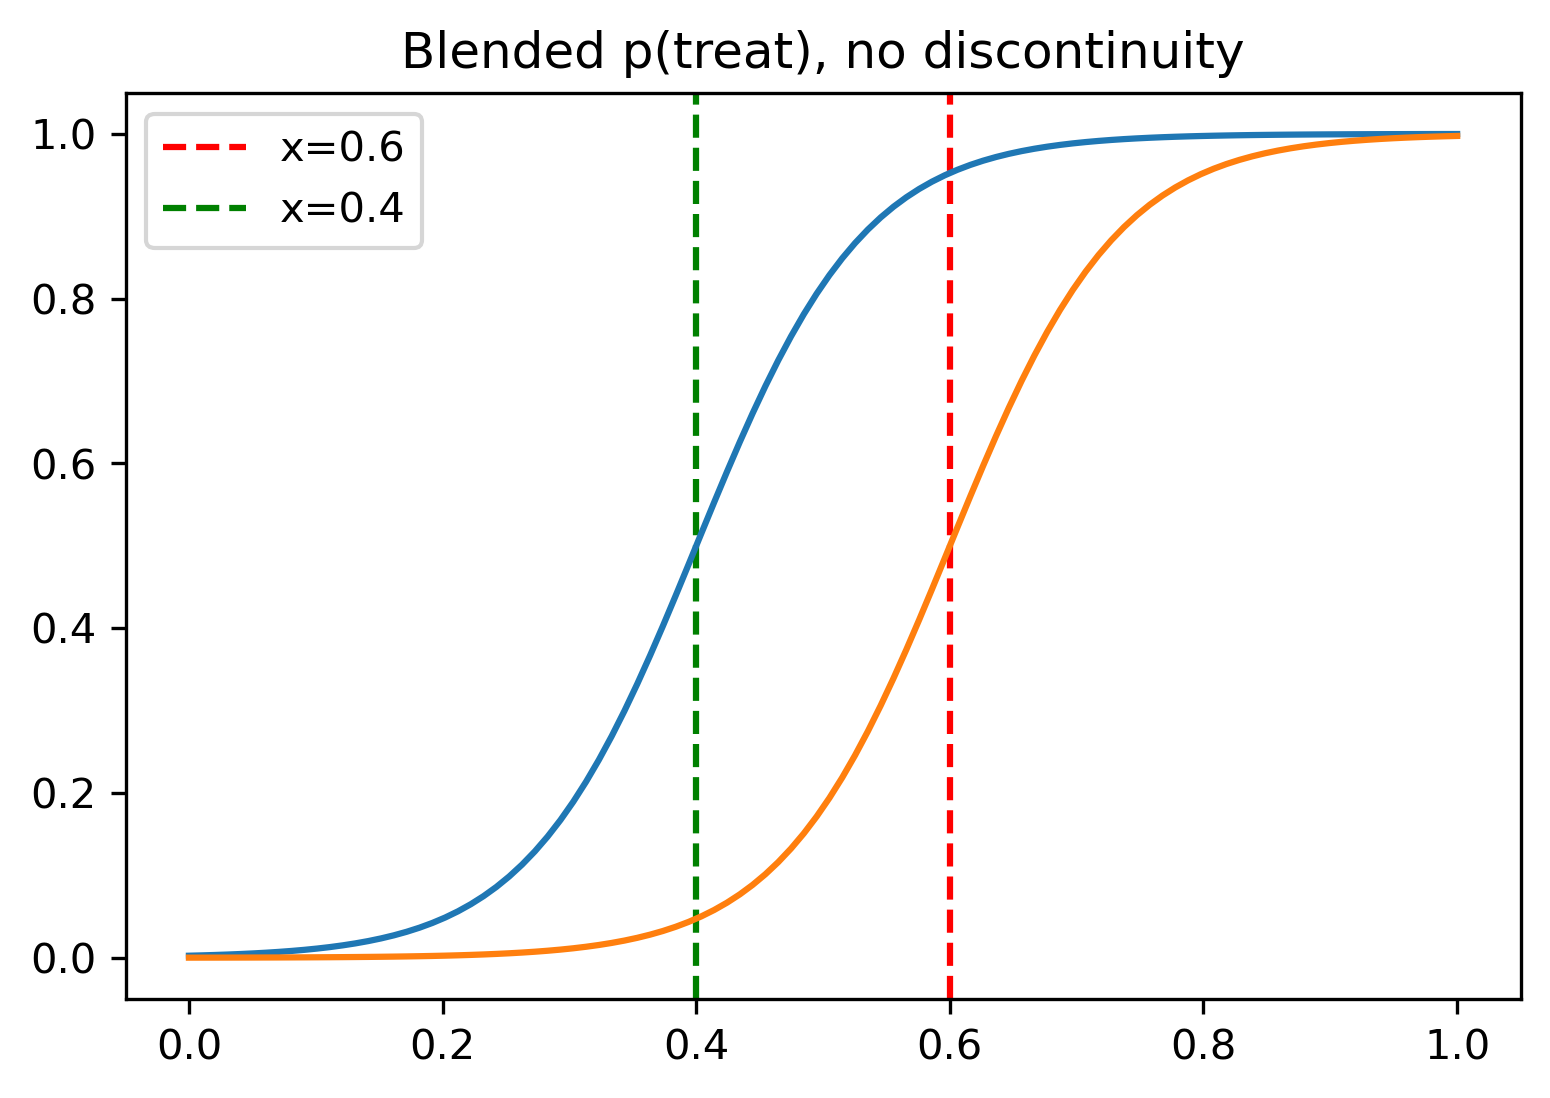

In [483]:
def sigmoid(x, location=0, scale=15):
    return 1 / (1 + np.exp(scale*(-x + location)))


x = np.linspace(0,1,100)
y1 = sigmoid(x, 0.4)
y2 = sigmoid(x, 0.6)
plt.axvline(0.6, ls='--', color='red', label="x=0.6")
plt.axvline(0.4, ls='--', color='green', label="x=0.4")
sns.lineplot(x,y1)
sns.lineplot(x,y2)
plt.title("Blended p(treat), no discontinuity")

In [464]:
def gen_sigmoid_data(n_samples, boundary=0.5, seed=0):
    np.random.seed(seed)

    # observed running variable
    x = np.random.uniform(0, 1, n_samples)

    # unobserved confounder
    u = np.random.normal(0, 0.1, n_samples)
    
    p_adj = sigmoid(x, boundary) + u
    p_adj = np.clip(p_adj, 0,1)

    # treatment indicator
    t = np.random.binomial(1, p_adj, n_samples)
    
    df = pd.DataFrame()
    df['x'] = x # running variable
    df['t'] = t # indicator for actual treatment assignment
    df['p'] = p_adj # true probability of treatment
    
    return df

In [465]:
n = 1000
df1 = gen_sigmoid_data(n, seed=0, boundary=0.4)
df2 = gen_sigmoid_data(n, seed=1, boundary=0.6)

df1['cat'] = 1
df2['cat'] = 0

neg_df = df1.append(df2)
neg_df = neg_df.sample(frac=1).reset_index(drop=True)

In [466]:
neg_df.head()

,x,t,p,cat
0,0.188745,0,0.139423,0
1,0.065961,0,0.000000,0
2,0.677141,1,1.000000,1
3,0.914789,1,1.000000,0
4,0.066149,0,0.000000,1


In [467]:
lr = LogisticRegression(random_state=0)
X = neg_df['x'].values.reshape(-1, 1)
print(X.shape)
lr.fit(X, neg_df['t'])
test_X = np.linspace(0,1,100).reshape(-1, 1)
preds = lr.predict_proba(test_X)[:, 1]

(2000, 1)


In [468]:
neg_df['x'].describe()

count    2000.000000
mean        0.498263
std         0.289562
min         0.000114
25%         0.248668
50%         0.494037
75%         0.747532
max         0.999809
Name: x, dtype: float64

In [469]:
neg_df['t'].describe()

count    2000.000000
mean        0.501000
std         0.500124
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: t, dtype: float64

## Propensity score

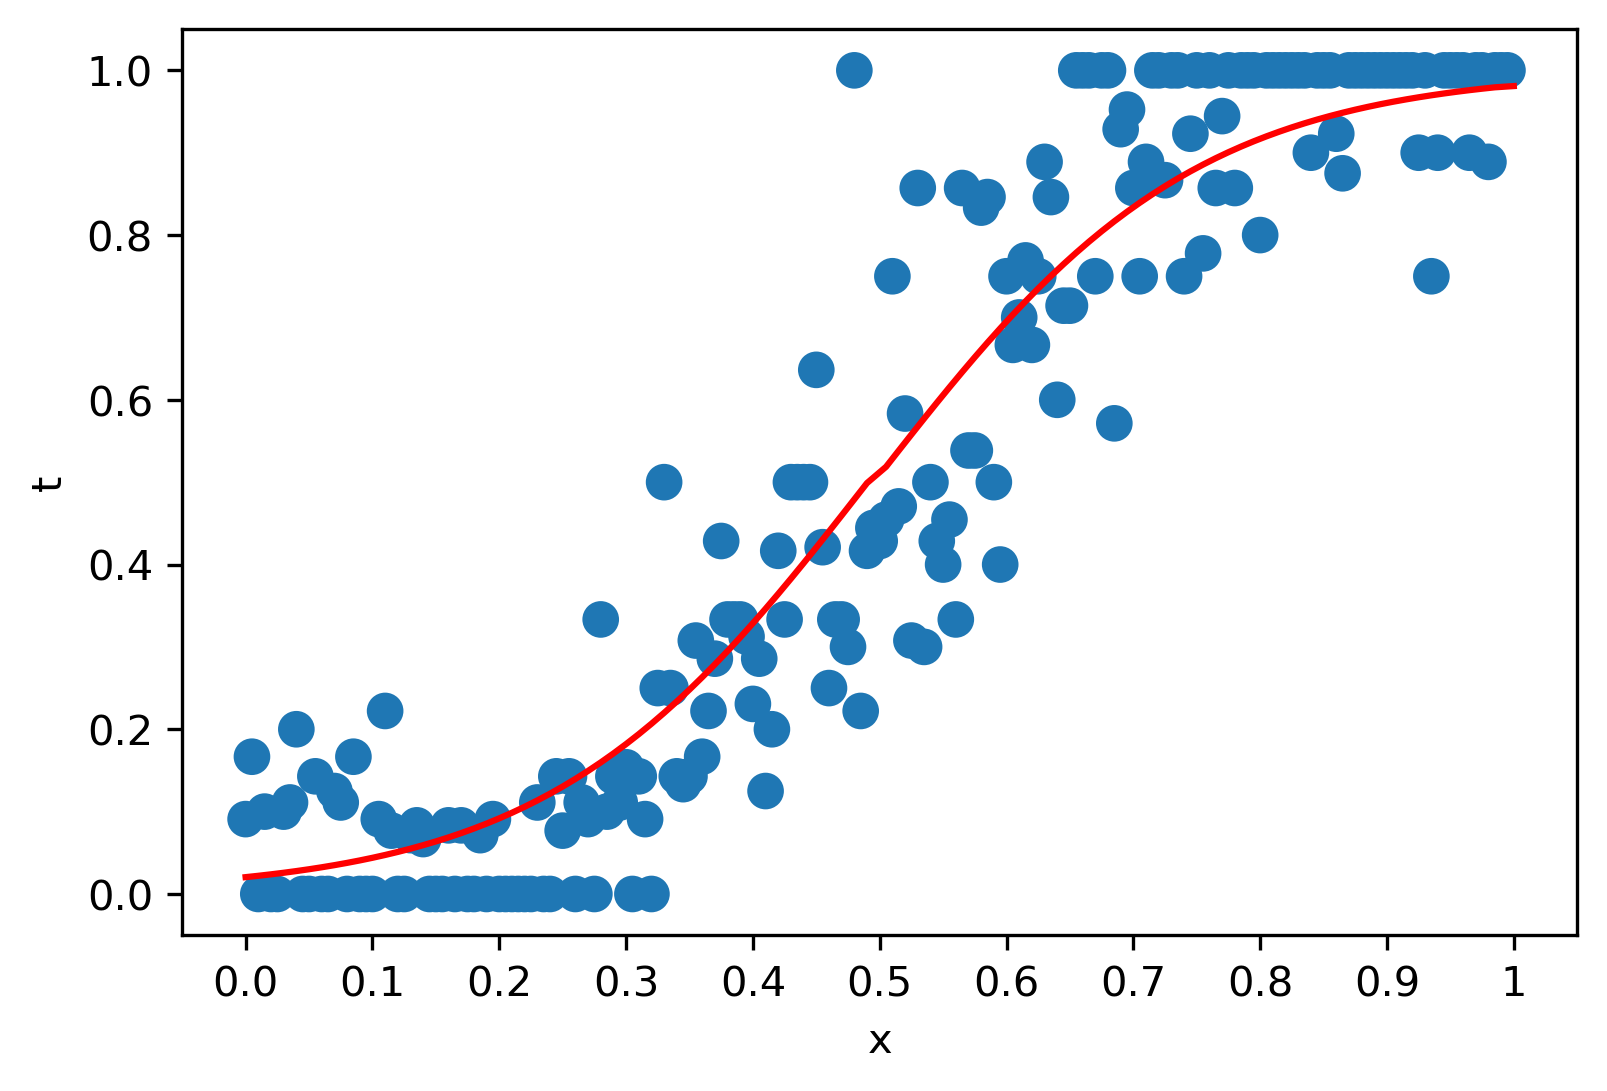

In [470]:
scale=200
point_plot('x', 't', neg_df, scale, errwidth=0)
disp_X = np.floor(test_X.flatten()*scale)
sns.lineplot(disp_X, preds, color='red')


## Probability treat

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/seaborn/distributions.py:437: UserWarning: The following kwargs were not used by contour: 'thresh', 'fill'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


([<matplotlib.axis.YTick at 0x7f43e6ff6450>,
 <a list of 2 Text major ticklabel objects>)

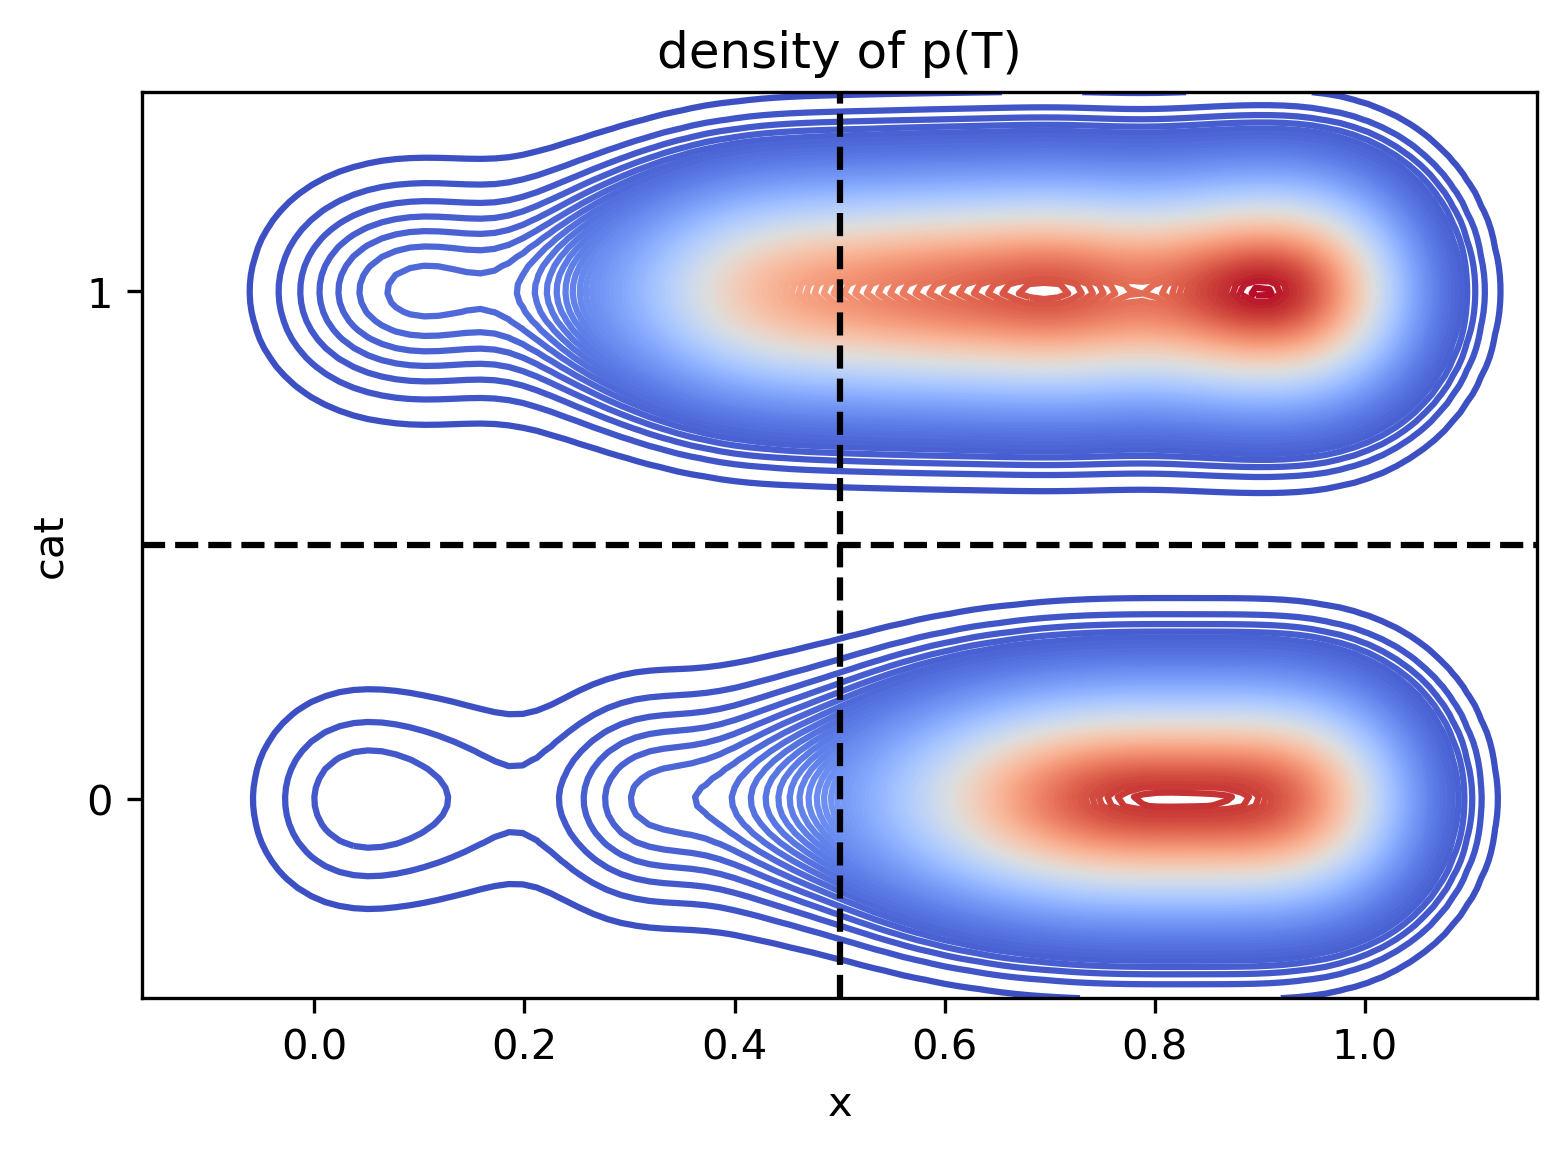

In [471]:
neg_t_df = neg_df[neg_df['t'] == 1]

sns.kdeplot(neg_t_df['x'], neg_t_df['cat'], thresh=0, levels=100, fill=True, cmap='coolwarm')
plt.axvline(x=0.5, ls='--', color='black')
plt.axhline(y=0.5, ls='--', color='black')
plt.title("density of p(T)")
plt.yticks([0,1])

## Predicted probability, LR

In [472]:
neg_lr = LogisticRegression(random_state=0)
X = neg_df[['x', 'cat']]
print(X.shape)
neg_lr.fit(X, neg_df['t'])

(2000, 2)


LogisticRegression(random_state=0)

In [473]:
x1s = np.linspace(0,1,100)
x2s = [0,1]

xx,yy = np.meshgrid(x1s,x2s, indexing='xy')

In [474]:
yy.shape

(2, 100)

In [475]:
probs = np.zeros((2,100))

for i in range(2):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]]).reshape(1,2)
        probs[i,j] = neg_lr.predict_proba(point)[0,1]

Text(0.5, 64.16666666666666, 'x')

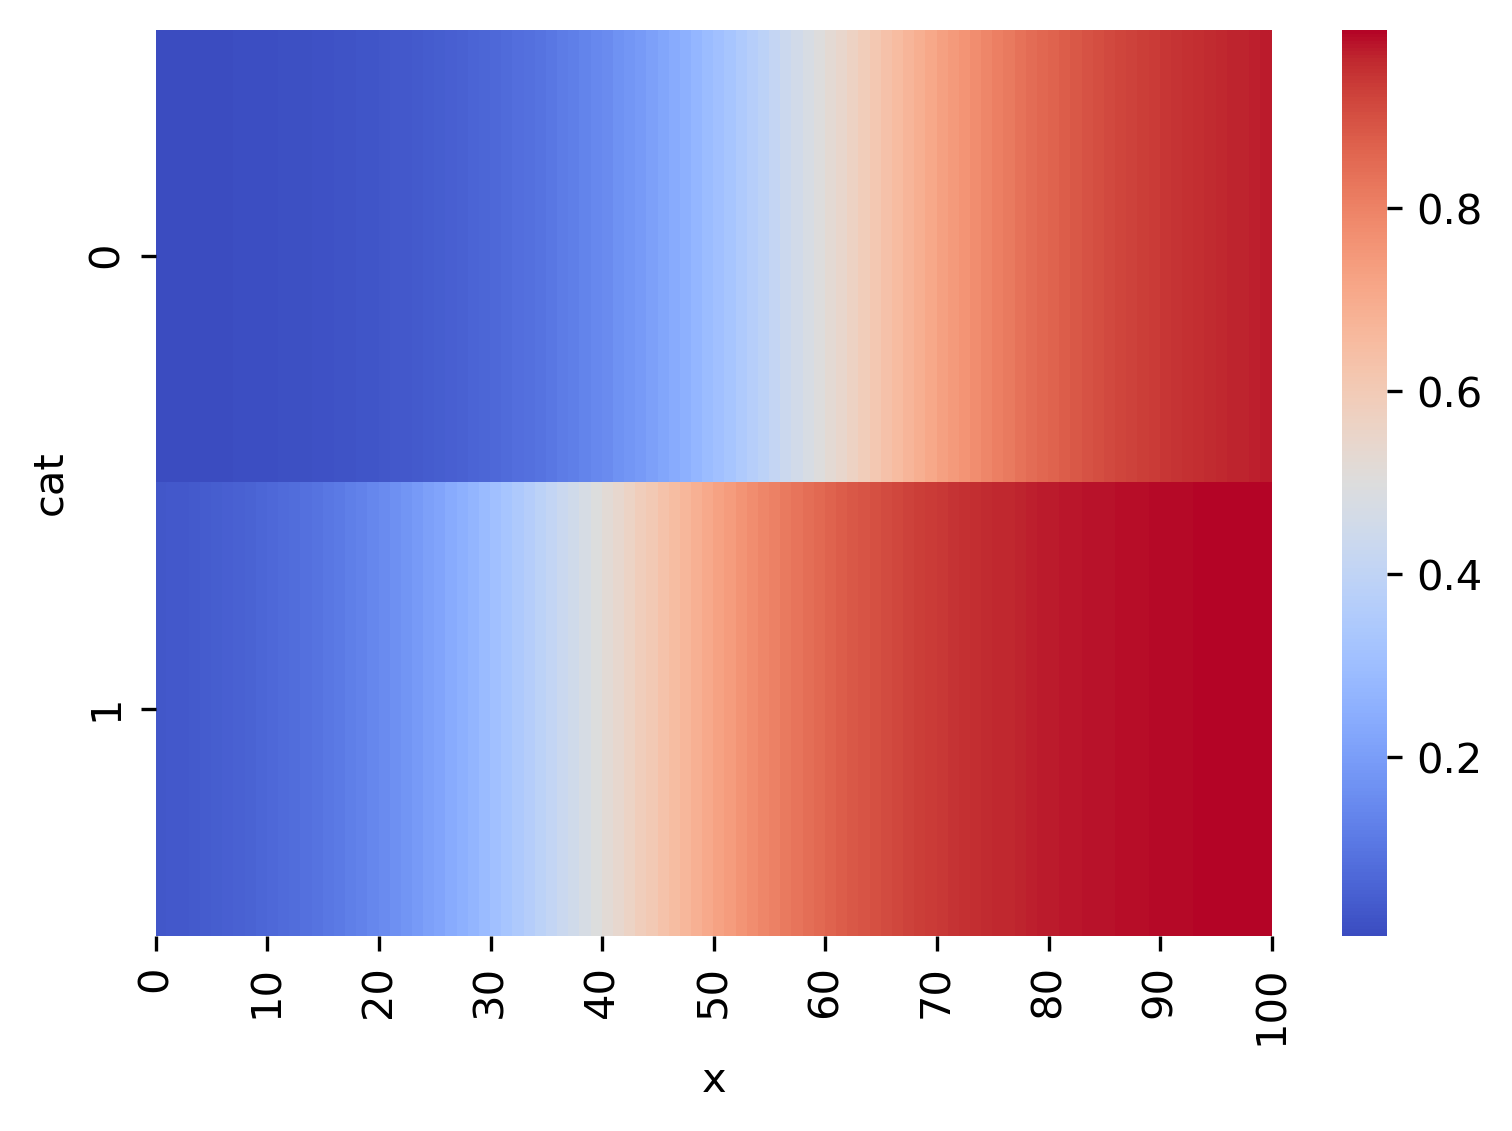

In [476]:
sns.heatmap(probs, center=0.5, cmap='coolwarm')

#plt.yticks([0.5,1.5], [1,0]);
plt.xticks(range(0,101,10), range(0,101,10))
plt.ylabel("cat")
plt.xlabel("x")

## Derivatives

In [479]:
%%time

dTdx_neg = np.zeros((2,100))

for i in range(2):
    for j in range(100):
        point = np.array([xx[i,j], yy[i, j]])#.reshape(1,2)
        result = get_partial(point, neg_lr)
        dTdx_neg[i,j] = result[0]

CPU times: user 114 ms, sys: 4.05 ms, total: 118 ms
Wall time: 111 ms


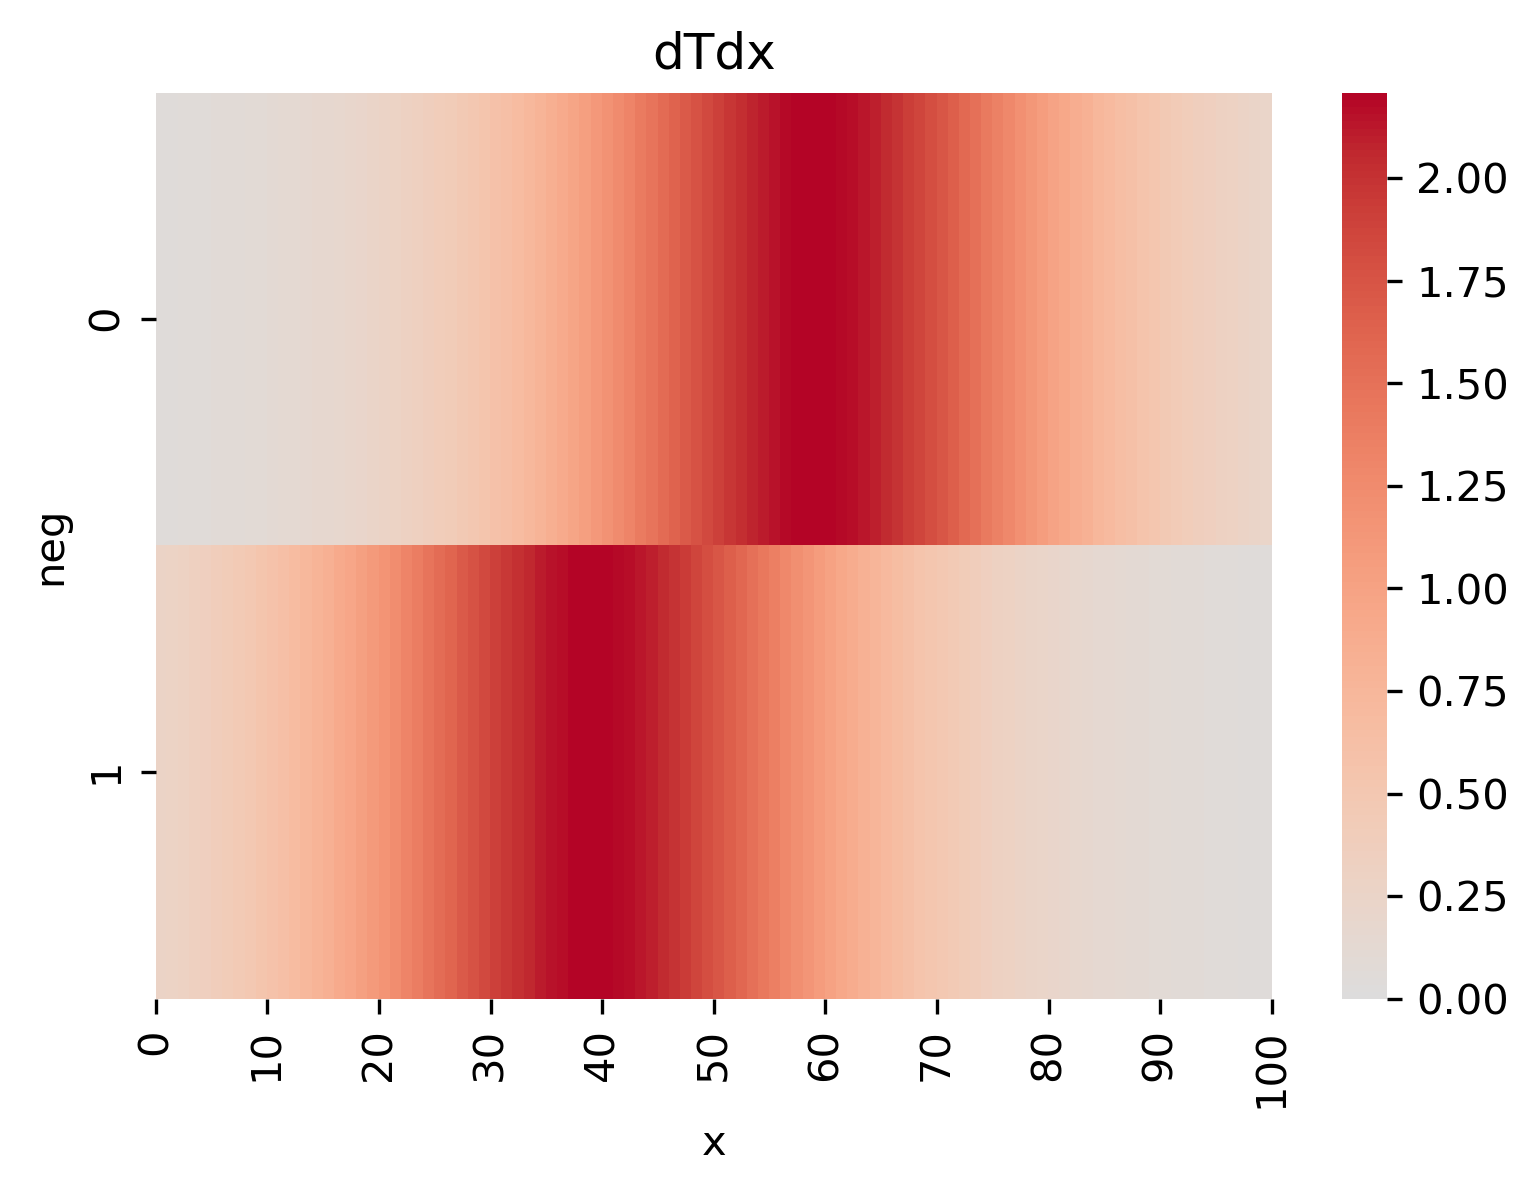

In [480]:
sns.heatmap(dTdx_neg, cmap='coolwarm', vmin=0, center=0)
plt.title("dTdx")
plt.xlabel("x")
plt.ylabel("neg")
plt.xticks(range(0,101,10), range(0,101,10));